# Predição de Consumo de Energia na Dinamarca

Este projeto tem como objetivo aplicar conhecimentos de ciência de dados correlacionado a análise e predição de **series temporais**. Serão explorados desde modelos mais clássicos, como AR, MA, ARMA, ARIMA, SARIMA até modelos de Machine Learning (Ridge, Random Forest e XGBoost).

A base de dados advém de uma API pública com diversos dados sobre o **mercado energético na Dinamarca**: https://en.energinet.dk/energy-data/data-catalog/

Os dados correspondem ao consumo de diversos ramos (Indústria, público e meio privado), além de possibilitar a análise de diversos municípios. A granularidade de dados é feita por hora.

Por fim, embora diversos municípios estejam disponíveis, utilizou-se apenas 1 como base do trabalho, devido ao volume de dados. 

O código do município é 101, correspondete a **København**, ou **Copenhague** em português, capital da Dinamarca.

![Text](https://studyindenmark.dk/why-denmark/quality-of-life-1/about-denmark/image_large)

Conseguir entender e prever os dados é de extrema importância. A gestão de energia é tema frequênte nos mais diversos paises e na Dinamarca **não seria diferente**. 

A energia é um dos principais insumos para a produção economica de um país. Prever sua demanda é prever o potêncial econômico dos próximos meses, assim como se antecipar a possíveis problemas que possam acontecer.

**A base de dados original conta com as seguintes colunas:**
- *HourUTC* : Data e horário com base no UTC internacional
- *HourDK* : Data e horário local - Fuso Dinamarques
- *MunicipalityNo* : Código do município da API. Usamos apenas o 101, corresponde a cidade de Copenhagem
- *Branche* : Corresponde ao tipo de ramo associado a ramo de atuação. Possui 3 valores principais sendo eles: Ind´sstria, Público e Privado
- *ConsumptionkWh* : O Consumo de energia em kWh



# 1. Instalando os requerimentos necessários

Import das bibliotecas usadas durante o projeto

In [2]:
import warnings
warnings.filterwarnings('ignore')

import requests
import pandas as pd
import numpy as np
import pmdarima as pm
import statsmodels as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from datetime import timedelta


#------ Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#------ Mlflow
import mlflow

#------ Machine Learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


#------ Pandas and Seaborn Options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('seaborn-colorblind');
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = 'warn'

# 2. Criando um experimento no Mlflow

Para o controle de métricas, armazenagem de modelos e arquivos, assim como avaliação das experimentação criada vamos usar o **Mlflow**.

O Mlflow ajuda no controle de métricas e versionamento de modelos. Sua UI pode ser vista com o código *mlflow ui* no terminal. Após isso, a porta 5000 disponibilizará a visão gráfica do experimento. 

Você pode acessa-la buscando por http://localhost:5000/ em seu navegador.

Para esse experimento o nome escolhido foi: '**Consumo_energia_dinamarca**'

A criação do experimento pode ser feita descomentando o código abaixo.

In [3]:
# mlflow.create_experiment('consumo_energia_dinamarca');

Setando o experimento escolhido. Como dito anteriormente seu nome é 'Consumo_energia_dinamarca' e pode ser associado usando:

*mlflow.set_experiment('name_experiment')*

In [4]:
mlflow.set_experiment('consumo_energia_dinamarca');

Traceback (most recent call last):
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 303, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 396, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1304, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1297, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 285, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\degio\Downloads\

<Experiment: artifact_location='file:///c:/Users/degio/Downloads/Estudos%202023/Personal%20Projects/Estudo%20de%20Energia%20Dinamarques/mlruns/264721167689002844', creation_time=1697676726078, experiment_id='264721167689002844', last_update_time=1697676726078, lifecycle_stage='active', name='consumo_energia_dinamarca', tags={}>

Iniciando a run do experimento. 

Tudo a partir daqui será linkado ao experimento criado.

In [5]:
run = mlflow.start_run()

# 3. Coletando dados da API

Como dito anteriormente, os dados são baseados na **API pública** de dados de energia da Dinamarca. 

Foi setado um limite de linhas buscadas e passado o código relativo a cidade de Copenhagem (101) como filtro da chamada da API.

In [6]:
max_rows = 100_000_000
city_code = "101"
url = 'https://api.energidataservice.dk/dataset/ConsumptionIndustry' + f"?limit={max_rows}" + '&filter={"MunicipalityNo":["' + city_code + '"]}'
data = requests.get(url)

Formatando os Dados para um DataFrame e typando as datas como datetime

In [7]:
df = pd.DataFrame(data.json()['records'])
df = df.astype({'HourDK': 'datetime64[ns]',
                'HourUTC':'datetime64[ns]'})

# 4. EDA

Uma análise exploratória foi realizada afim de entender o comportamento dos dados do Dataframe.

In [8]:
df.head()

,HourUTC,HourDK,MunicipalityNo,Branche,ConsumptionkWh
0,2023-11-11 22:00:00,2023-11-11 23:00:00,101,Erhverv,143626.22
1,2023-11-11 22:00:00,2023-11-11 23:00:00,101,Offentligt,27785.51
2,2023-11-11 22:00:00,2023-11-11 23:00:00,101,Privat,51096.70
3,2023-11-11 21:00:00,2023-11-11 22:00:00,101,Erhverv,155024.71
4,2023-11-11 21:00:00,2023-11-11 22:00:00,101,Offentligt,28363.44


Vamos traduzir alguns nomes para facilitar a avaliação.

- *Erhverv*: Meio Industrial
- *Offentligt*: Meio Público
- *Privat*: Meio Privado

In [9]:
dic = {'Erhverv': 'Meio Industrial', 
       'Offentligt': 'Meio Público',
       'Privat': 'Meio Privado' }

df['Ramo'] = df['Branche'].map(dic)

#Removendo as colunas que não serão utilizadas
df.drop(['Branche', 'HourUTC', 'MunicipalityNo'], axis = 1, inplace = True)

In [10]:
df.info()
# Aparentemente não temos dados nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75240 entries, 0 to 75239
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   HourDK          75240 non-null  datetime64[ns]
 1   ConsumptionkWh  75240 non-null  float64       
 2   Ramo            75240 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.7+ MB


In [11]:
df.describe()

,HourDK,ConsumptionkWh
count,75240,75240.00
mean,2022-06-07 12:07:22.679425792,88272.05
min,2021-01-01 00:00:00,22092.97
25%,2021-09-19 06:45:00,32688.66
50%,2022-06-07 12:30:00,55072.73
75%,2023-02-23 17:15:00,142120.75
max,2023-11-11 23:00:00,266020.43
std,NaN,66168.65


Começamos avaliando a distribuição de valores de consumos em kWh usando um histograma.

Vemos consumos que tem valores de escalas diferentes dos menores percentis de dados. Muito provavelmente essa diferença possa estar associada ao tipo de ramo de negócio na descrição dos dados.

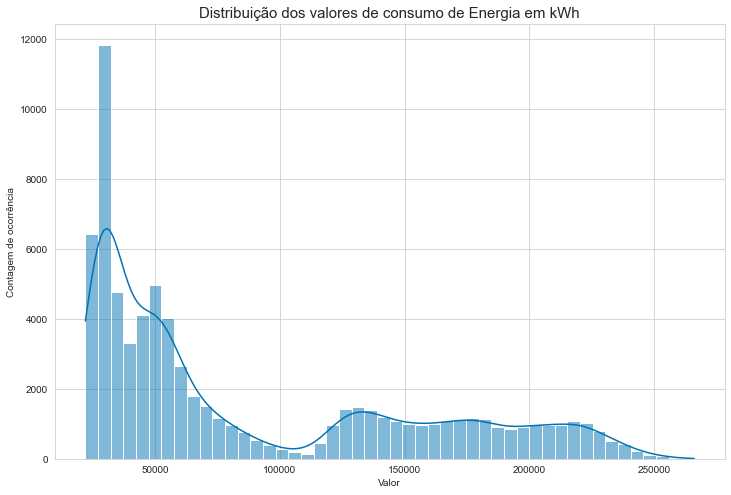

In [12]:
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x = 'ConsumptionkWh', kde = True)
ax.set_title('Distribuição dos valores de consumo de Energia em kWh', fontsize=15)
ax.set_xlabel('Valor', fontsize=10)
ax.set_ylabel('Contagem de ocorrência', fontsize=10)
plt.show()

Plotando o histograma de dados podemos perceber que há dois principais "perfis". Um associado a consumos mais baixos e com grande volume e outro com volumes mais distribuidos, mas com uma média de valor bem acima do primeiro pico.

Vamos discretizar o gráfico em ramos de atuação. 

Ficará mais fácil medir o impacto de cada tipo de negócio.

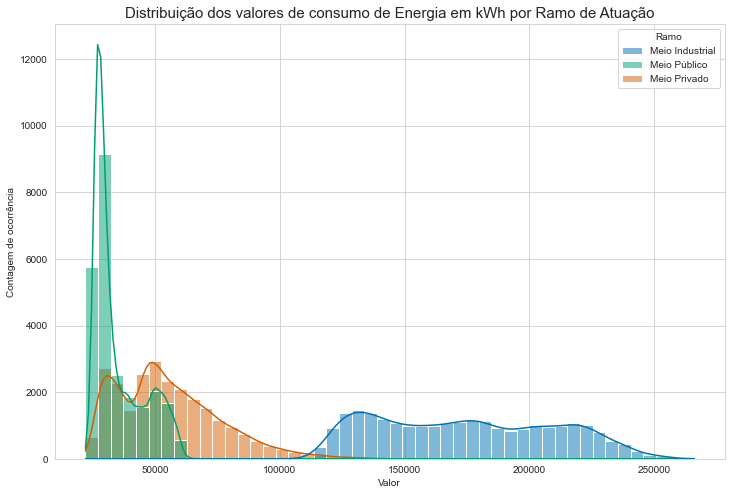

In [13]:
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x = 'ConsumptionkWh', kde = True, hue = 'Ramo')
ax.set_title('Distribuição dos valores de consumo de Energia em kWh por Ramo de Atuação', fontsize=15)
ax.set_xlabel('Valor', fontsize=10)
ax.set_ylabel('Contagem de ocorrência', fontsize=10)
plt.show()

Aqui alguas análises já podem ser feitas. 

Percebe-se que a distribuição total é a "soma" das distribuições por ramo. Como era de se esperar, o **ramo industrial** tem uma aplitude de valor consumido muito maior que os outros ramos, além de sua distribuição ser mais **"flat"**. 

A distribuição dos valores do **meio privado** parecem uma distribuição **assimétrica**, tendo uma cauda longa a direita. Além disso, os valores parecem menos bem distribuidos que o meio industrial. Por fim, a média aparenta ser maior maior que o ramo público

Por fim, o ramo público tem uma **assimetria grande**, tendo seus valores concentrados em **baixos valores** de consumo e que não chegam perto dos valores de ramos industrial e privado.

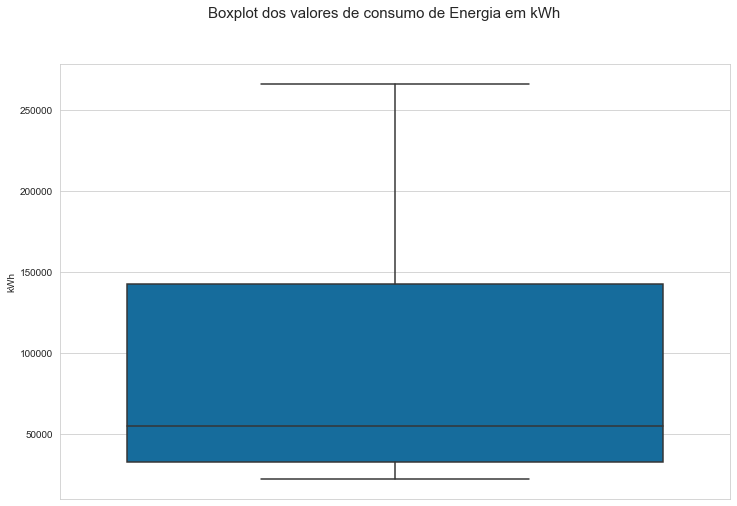

In [14]:
fig = plt.figure(figsize=(12,8))
sns.boxplot(data = df, y = 'ConsumptionkWh')
fig.suptitle('Boxplot dos valores de consumo de Energia em kWh', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.show()

O boxplot individualmente não nos da muita informação sobre os dados. Vamos novamente dicretizar por meio de atução.

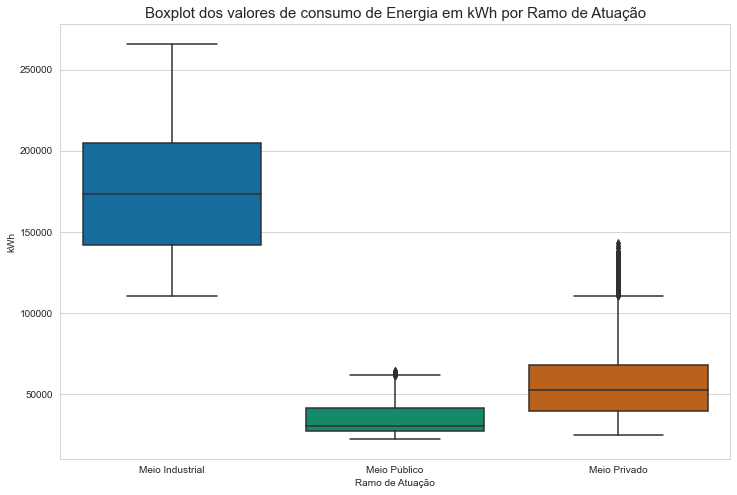

In [15]:
plt.figure(figsize=(12,8))
sns.boxplot(data = df, y = 'ConsumptionkWh', x = 'Ramo')
plt.title('Boxplot dos valores de consumo de Energia em kWh por Ramo de Atuação', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Ramo de Atuação', fontsize=10)
plt.show()

Os mesmos insights da análise de cima podem ser vistos aqui. 

A distribuição e comportamento de ramos é bem diferente entre si. Cada ramo de atuação tem um **perfil** de consumo. 

O perfil industrial se destaca por ser **bem diferente** dos outros dois. 

# 5. Análise de série temporal - Horas

Como dito, a serie temporal está descrita em horas. 

Para que consigamos trabalhar de forma mais fácil vamos passar o horário como índice de nosso dataframe e fazer com que os ramos de atuação se transformem em colunas

In [16]:
df_hour = df.set_index('HourDK')
df_hour = pd.pivot_table(data= df_hour,values = 'ConsumptionkWh', index = df_hour.index, columns = 'Ramo')
df_hour

Ramo,Meio Industrial,Meio Privado,Meio Público
HourDK,,,
2021-01-01 00:00:00,135639.68,62043.36,27598.62
2021-01-01 01:00:00,134312.26,57641.06,27333.59
2021-01-01 02:00:00,131755.79,51661.89,27193.94
2021-01-01 03:00:00,129231.29,45865.41,27163.74
2021-01-01 04:00:00,130280.39,40869.73,27371.50
...,...,...,...
2023-11-11 19:00:00,184125.13,83658.97,31258.67
2023-11-11 20:00:00,173935.36,73269.65,30324.31
2023-11-11 21:00:00,166385.58,65970.57,29429.57


Vamos dar uma olhada nas séries temporais de cada ramo.

Para isso criamos uma função que nos ajudará a plotar o gráfico repetidamente.

In [17]:
def plot_series(df, fig_save, title):

    fig, ax = plt.subplots(figsize = (12,8))
    sns.lineplot(data = df, x = df.index, y = df['Meio Industrial'], ax = ax)
    sns.lineplot(data = df, x = df.index, y = df['Meio Privado'], ax = ax)
    sns.lineplot(data = df, x = df.index, y = df['Meio Público'], ax = ax)
    plt.title(title, fontsize=15)
    plt.ylabel('kWh', fontsize=10)
    plt.xlabel('Data', fontsize=10)


    plt.show();

    mlflow.log_figure(fig, 'fig_save.png')

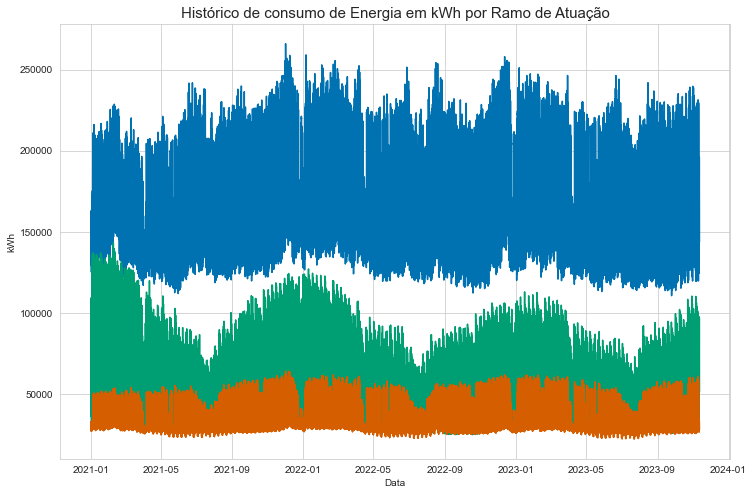

In [18]:
plot_series(df_hour, 'Figure_hour_complete.png', 'Histórico de consumo de Energia em kWh por Ramo de Atuação')

Podemos ver novamente que os valores medidos em ramos industriais são muito mais altos que outros. 

Porém, como estamos vendo os dados em uma resolução de horas, temos que isso acaba prejudicando a visualização. Vamos selecionar uma *amostra de 2 meses* para ver se conseguimos perceber algum comportamento sazional.

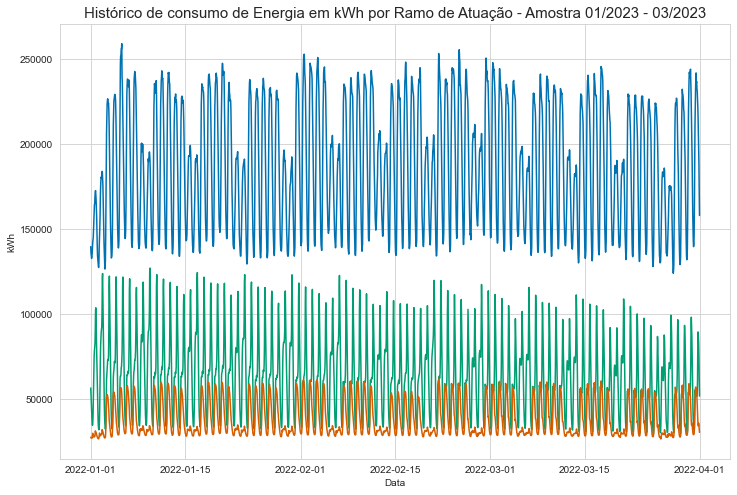

In [19]:
plot_series(df_hour['01-2022':'03-2022'], 'Figure_hour_complete_sample_2_monhts.png','Histórico de consumo de Energia em kWh por Ramo de Atuação - Amostra 01/2023 - 03/2023' )

Podemos começar a perceber alguns padrões sazionais, aparentemente **semanais**, o que era de se esperar, pois o comsumo tende a ser mais frequênte durante os dias úteis e cair durante o final de semana.

Vamos dar um "zoom" ainda maior.

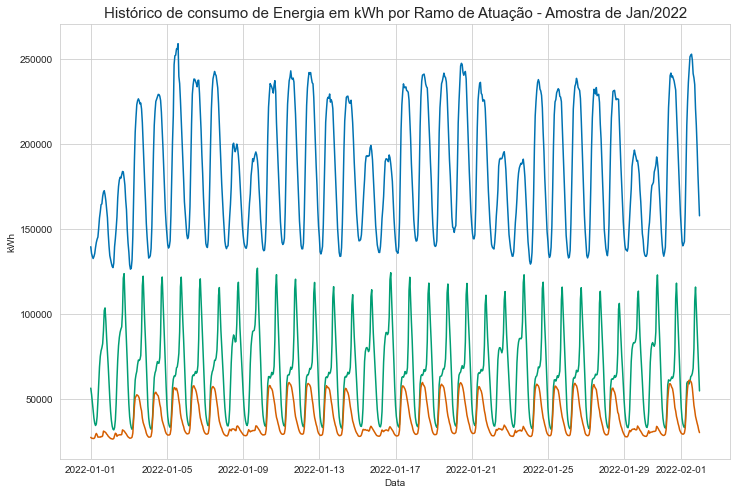

In [20]:
plot_series(df_hour['01-01-2022':'02-01-2022'], 'Figure_hour_sample_1_month.png','Histórico de consumo de Energia em kWh por Ramo de Atuação - Amostra de Jan/2022' )

Com uma amostra ainda menor fica mais sensivel ainda a questão de sazionalidade de consumo.

Percebe-se também uma comportamente levemente diferente do **ramo público e privaddo**. 

Destaque para o ramo privado, que parece ter um pico de consumo em alguns **horários do dia**, muito provavelmente correlacionados ao **horário de trabalho**. 

Temos aparentemente para essa série duas sazionalidades: **Semanal e diária**.

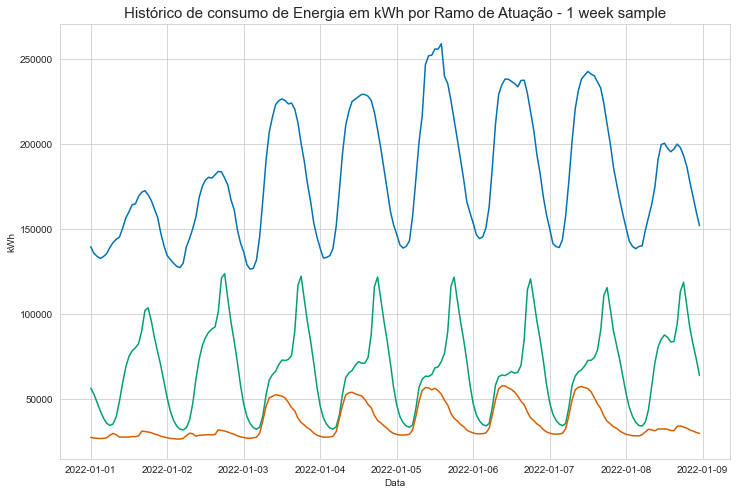

In [21]:
plot_series(df_hour['01-01-2022':'01-08-2022'], 'Figure_hour_sample_1_week.png','Histórico de consumo de Energia em kWh por Ramo de Atuação - Amostra de 1 semana' )

Aqui fica mais visivel a sazionalidade diária do **ramo privado**. 

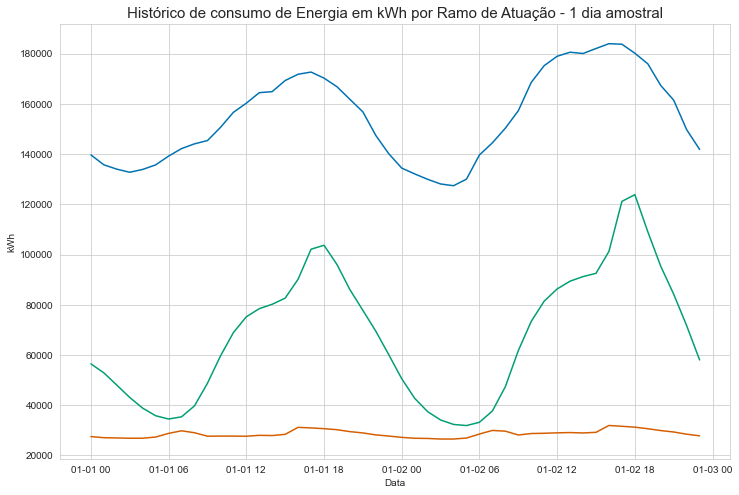

In [22]:
plot_series(df_hour['01-01-2022':'01-02-2022'], 'Figure_hour_sample_1_day.png','Histórico de consumo de Energia em kWh por Ramo de Atuação - 1 dia amostral' )

Na análise diária fica bem claro o comportamento em menor grau, avaliando o **horário dos picos e vales**. 

Os horários de pico parecem acontecer ao final da tarde, seguidos de uma queda abrupta de consumo.

# 6. Análise de série temporal - Dia

A análise horária é ótima para indentificar padrões de consumo em menor **nível de escala**. Porém, sendo o objetivo desse projeto uma previsão dos próximos dias/meses de consumo, pode ser que trabalhar com a **escala de horas não beneficie a modelagem**.

Por esse motivo, a partir deste momento todas as análises serão realizadas avaliando o **consumo diário**. 

O consumo diário é considerado como a **soma dos kWh** consumidos durante todo o perído de 1 dia.



In [23]:
df_ = df.copy()

Fazendo um resample da amostra de dados para uma resolução diária.

In [24]:
df_day = df_.set_index('HourDK')
df_day = pd.pivot_table(data= df_day,values = 'ConsumptionkWh', index = df_day.index, columns = 'Ramo')
df_day= df_day.resample('D').sum()
df_day

Ramo,Meio Industrial,Meio Privado,Meio Público
HourDK,,,
2021-01-01,3508699.10,1655304.73,718233.54
2021-01-02,3614385.41,1750107.12,693222.32
2021-01-03,3632311.50,1791945.10,691927.60
2021-01-04,4235753.30,1765399.12,900495.79
2021-01-05,4218880.91,1768094.64,911664.56
...,...,...,...
2023-11-07,4399539.00,1344155.20,977036.03
2023-11-08,4409916.12,1340425.36,981289.02
2023-11-09,4418701.09,1363000.33,998634.58


Armazenado a tabela no experimento para possivel futura consulta

In [25]:
mlflow.log_table(df_, 'tabela_dados_resample_day.csv')
df_.to_parquet('tabela_dados_resample_day.parquet')

Vamos plotar o novo gráfico, agora com a resolução em dias.

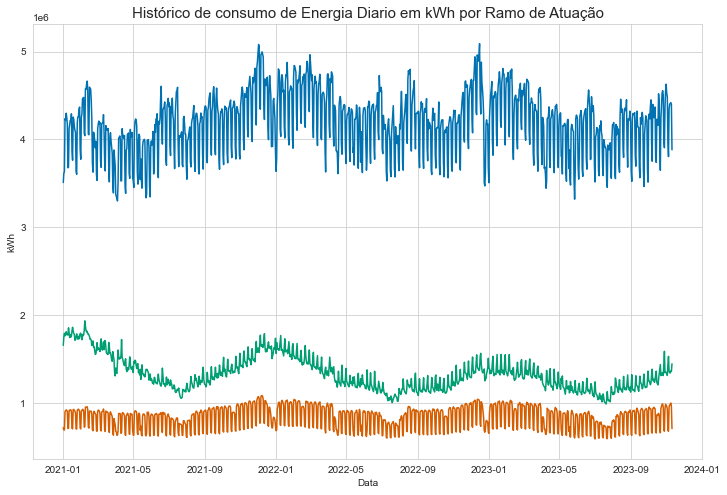

In [26]:
plot_series(df_day, 'Figure_day_complete.png','Histórico de consumo de Energia Diario em kWh por Ramo de Atuação' )

Aqui os padrões não parecem tão claros. Ainda sim, conseguimos perceber uma certo comportamento de *alta seguida de queda* do ramo privado (Verde).

Vamos pegar uma amostra e ver como o gráfico em menor resolução.

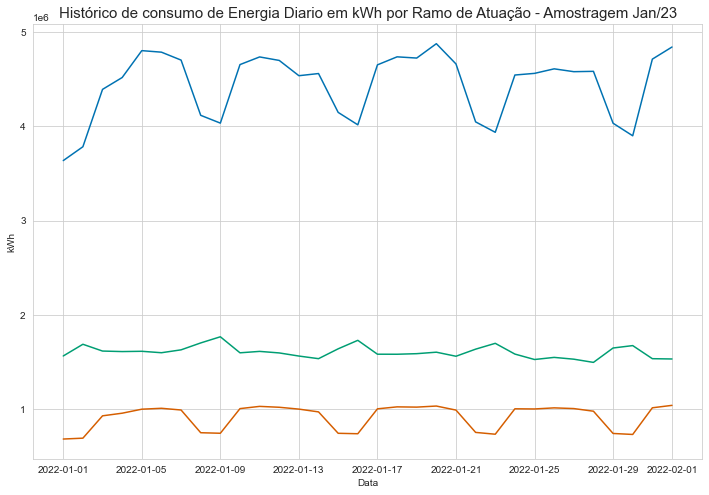

In [27]:
plot_series(df_day['01-01-2022':'02-01-2022'], 'Figure_day_complete_month.png','Histórico de consumo de Energia Diario em kWh por Ramo de Atuação - Amostragem Jan/23' )

Aqui vemos claramente a sazionalidade semanal, como já visto nos gráficos acima, porém sem tanto ruído.

Avaliando o período de 1 mês alguns padrões começam a fica mais claros.

Para a série de dados do **meio público** percebe-se uma grande **estabilidade durante os dias da semana** e uma queda durante o final de semana. 

Para o ramo privado há um pico de c**onsumo durante os domingos e sabados**. Muito provavelmente isso é puxado pela d**emanda das pessoas comuns que durante os finais de semana** saem de casa e vão a passeios, restaurantes, shows, academia e mais, puxando a alta de demanda e consequentemente a alta de consumo de energia.

Por fim, para o ramo industrial há uma forte queda de consumo durante os **finais de semana**. Durante os dias úteis o consumo é relativamente alto, mas **não tão estável**, principalmente se compardo ao ramo público

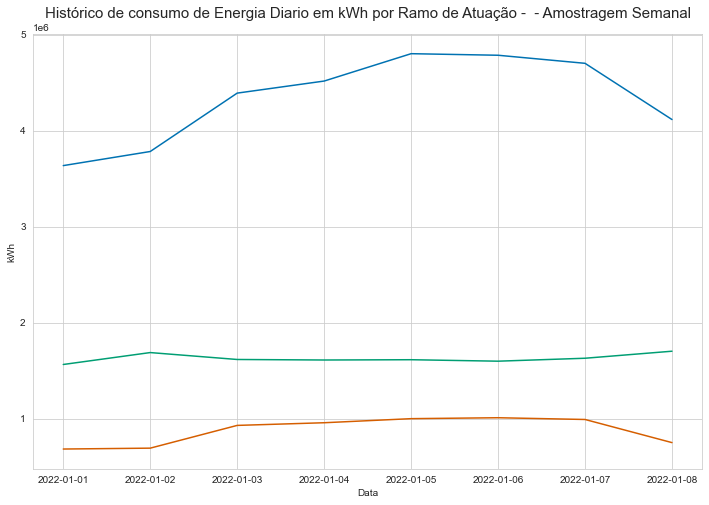

In [28]:
plot_series(df_day['01-01-2022':'01-08-2022'], 'Figure_day_complete_week.png','Histórico de consumo de Energia Diario em kWh por Ramo de Atuação -  - Amostragem Semanal' )

#### Janelas deslizantes e Comportamento Sazional

Para a melhor avaliação da série temporal vamos usar de *janelas deslizantes* para gerar gráficos de *médias móveis*.

Isso pode ser de grande valia quando queremos ver os comportamentos de forma **menos ruidosa**.

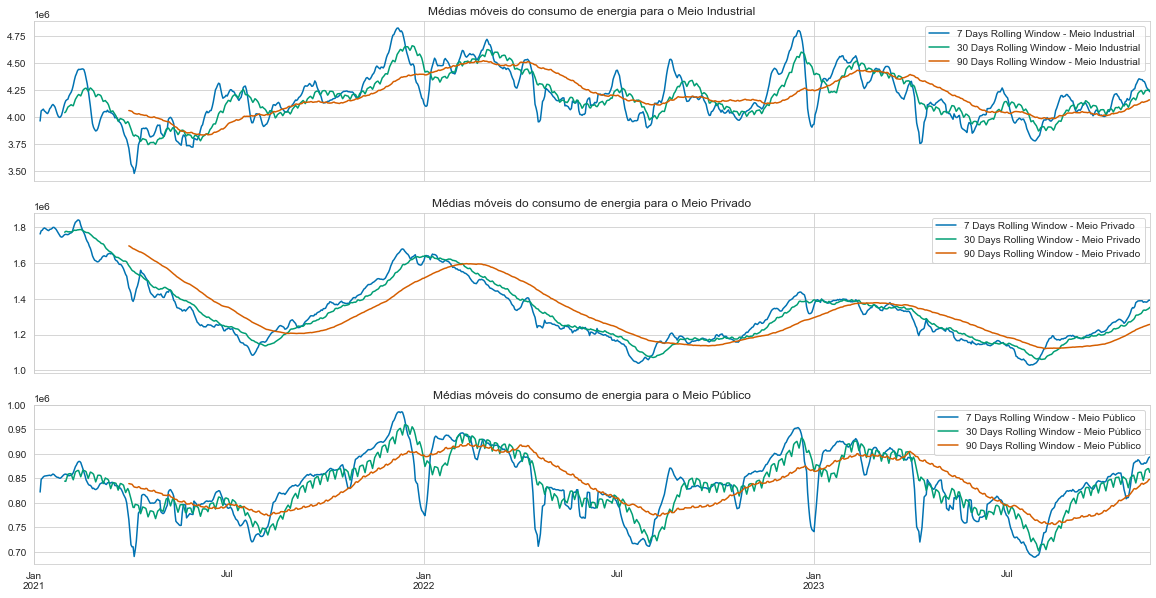

In [29]:
fig, ax = plt.subplots(nrows =3,figsize = (20,10), sharex = True)

for i, col in enumerate(df_day.columns):
    df_day[col].rolling(window= 7).mean().plot(ax = ax[i])
    df_day[col].rolling(window= 30).mean().plot(ax = ax[i])
    df_day[col].rolling(window= 90).mean().plot(ax = ax[i])
    ax[i].set_title(f'Médias móveis do consumo de energia para o {col}')
    ax[i].set_xlabel('') 
    ax[i].legend([f'7 Days Rolling Window - {col}', f'30 Days Rolling Window - {col}', f'90 Days Rolling Window - {col}'])

Como era de se esperar, uma janela deslizante maior trás uma **suavização** muito mais acentuada que um tempo menor. Podemos ver isso comparando os resultados da janela deslizante de 7 dias contra a de 90 dias. 

Apesar disso, em avaliações de longos períodos percebemos que os três meios tem **comportamento sazional anual**, igualando seus **períodos de vales e picos** na média movel de 90 dias.

Percebemos para os ramos industriais e públicos uma incidência de quedas acentuadas nos meses de **Janeiro, Março e Agosto**.

Fora isso, percebe-se uma estabilidade de consumo nos 2 últimos anos, **sem uma tendência clara de queda ou crescimento**.

Para a melhor visualização da tendências sazionais mensais, vamos agrupar os meses e avaliar comportamento similares nos anos.

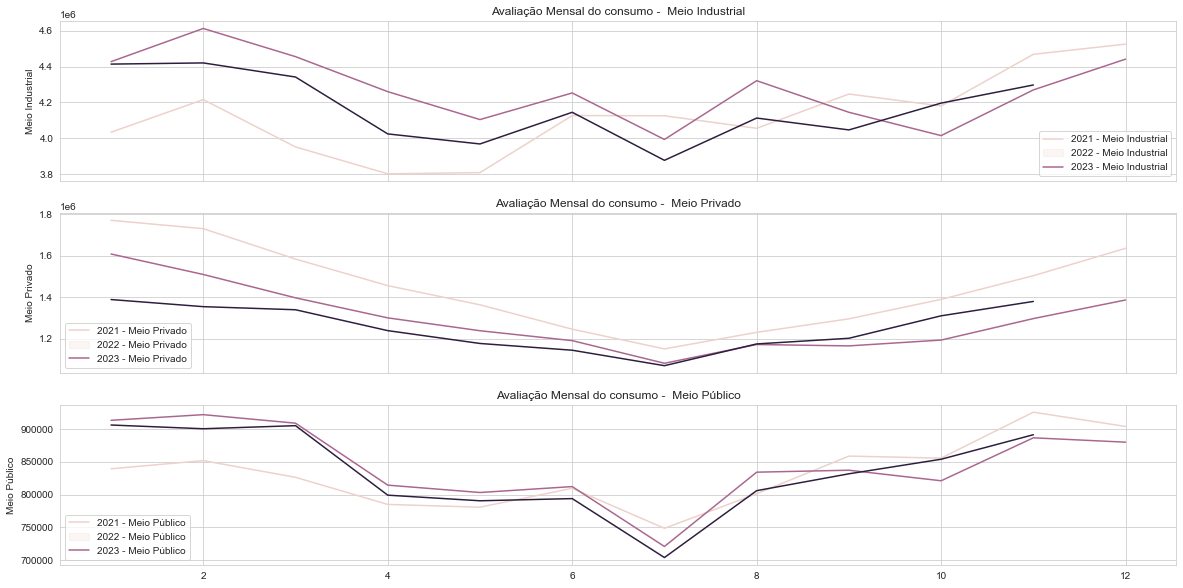

In [30]:
df_season = df_day.groupby([df_day.index.month, df_day.index.year]).mean()
df_season.index = df_season.index.set_names(['Month', 'Year'])
df_season.reset_index(inplace=True)

fig, ax = plt.subplots(nrows =3,figsize = (20,10), sharex = True)

for i, col in enumerate(df_day.columns):
    sns.lineplot(data = df_season, x = 'Month', hue='Year', y = col, ax = ax[i])
    ax[i].set_title(f'Avaliação Mensal do consumo -  {col}')
    ax[i].set_xlabel('') 
    ax[i].legend([f'2021 - {col}', f'2022 - {col}', f'2023 - {col}'])
plt.show();

Aqui fica ainda mais claro a acentuada **queda de consumo** nos meses de **Julho**, em todos os ramos de negócio.

Vamos fazer a mesma avaliação para avaliar se temos algum tipo de sazionalidade por dia.

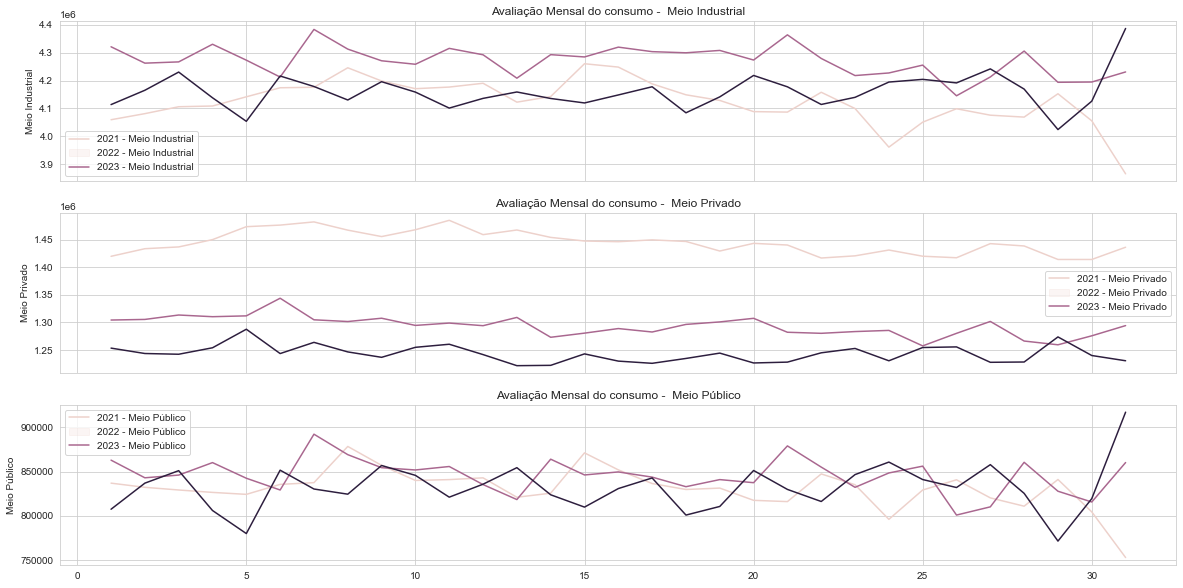

In [31]:
df_season = df_day.groupby([df_day.index.day, df_day.index.year]).mean()
df_season.index = df_season.index.set_names(['Day', 'Year'])
df_season.reset_index(inplace=True)


fig, ax = plt.subplots(nrows =3,figsize = (20,10), sharex = True)

for i, col in enumerate(df_day.columns):
    sns.lineplot(data = df_season, x = 'Day', hue='Year', y = col, ax = ax[i])
    ax[i].set_title(f'Avaliação Mensal do consumo -  {col}')
    ax[i].set_xlabel('') 
    ax[i].legend([f'2021 - {col}', f'2022 - {col}', f'2023 - {col}'])
plt.show();

Aqui sim temos um gráfico bem interessante. Para o Meio privado a **estabilidade é muito grande**, percebe-se que não há dias de destaque com aumento ou queda de consumo.

Para o Meio Público tem-se uma grande oscilição conforme os dias vão chegando ao final do Mês. 

Já para o Meio industrial, embora ocorra certa oscilação, ela não chega a permitir uma conclusão bem definida.

#### Análise de Estacionariedade e Distribuição das diferenças

Um dos grandes pontos a se avaliar quando queremos prever o comportamento de uma série temporal é sua **estacionariedade**. Para que uma série seja considerada estacionária os seguintes requirementos são necessários:

- *A série precisa ter média constante*
- *A série precisa ter variância constante*
- *Não possuir tendência*

Em suma, a série precisa manter suas **propriedades estatísticas mais ou menos constantes com o tempo**. Podemos avaliar a estacionariedade de uma série de maneira gráfica, mas o mais recomendado é que usemos de **testes estatísticos** para isso!

Um dos testes mais famosos para tal é o **Augmented Dickey-Fuller Test, ou ADF**. Se o p-value do teste for menor que 0.05 podemos rejeitar com 95% de confiança a hipótese nula de que a série possui uma raiz unitária (E assim seria não estacionária).

Se o valor então for **menor que 0.05**, temos uma serie considerada estacionária.

Daqui para a frente vamos escolher apenas uma dos meios (Industrial, Público e Privado) estudado.

Tudo que for desenvovido pode ser replicado para os outros dois meios ou até mesmo outra serie temporal.

Vamos escolher o *meio Industrial*, por ser o volume mais representativo.

In [32]:
df_day_ind = pd.DataFrame(df_day['Meio Industrial'])

In [33]:
# Vamos fazer um teste de estacionariedade para avaliar a serie temporal
results = sm.tsa.stattools.adfuller(df_day_ind)
print(f'O resultado do p-value para o teste é de {round(results[1],5)}')

O resultado do p-value para o teste é de 0.0052


O valor obitido foi muito próximo do valor desejado de 0.05, mas ainda *superior* a ele. Uma das formas de tornar uma série estacionária é **diferenciar** os seus dados, por padrão testamos a primeira diferenciação, mas outros métodos de transformação (Log ou raiz quadrada) também podem ser usados.

Vamos extrair a primeira diferenciação e testar a estacionariedade da série novamente. 

Após isto vamos plotar também a distribuição da série diferenciada.

In [34]:
# Vamos fazer um teste de estacionariedade para avaliar a serie temporal
results = sm.tsa.stattools.adfuller(df_day_ind.diff(1).dropna())
print(f'O resultado do p-value para o teste é de {round(results[1],10)}')

O resultado do p-value para o teste é de 0.0


Agora sim! **Série devidamente estacionária**. Vamos dar uma olhada nos resíduos.

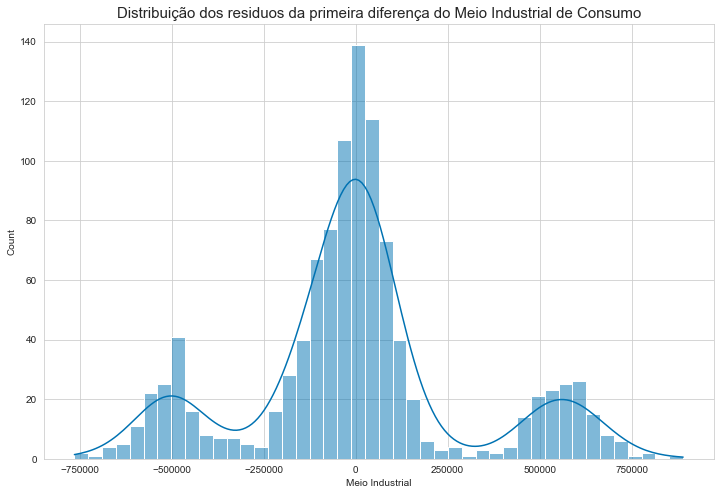

In [35]:
# Histograma da primeira diferença
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df_day_ind.diff(1).dropna(), x = 'Meio Industrial', kde = True)
plt.title('Distribuição dos residuos da primeira diferença do Meio Industrial de Consumo', fontsize=15)
plt.show()

Ainda que a série se apresente como escionária segundo o ADF, percebemos que os resíduos tem duas tendências que *diferem de zero*, sendo uma positiva e outra negativa.

# 6. Modelagem e Predição da Serie Temporal via modelos ARIMA e SARIMA

Vamos começar a explorar a modelagem e forecast de series temporais. 

Como dito anteriormente, há diversas maneiras de se compreender tal tarefa, mas por equanto vamos trabalhar com uma **modelagem mais clássica**, usando de modelos **ARIMA** e **SARIMA** para realizar a previsão de pontos futuros.

Vamos pegar uma amostra mensal e rever a tendência do consumo no Meio Industrial

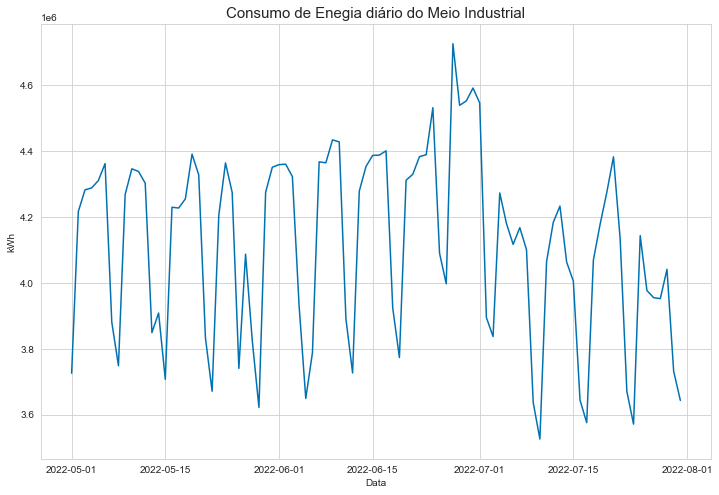

In [36]:
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day_ind['05-2022':'07-2022'], x = df_day_ind['05-2022':'07-2022'].index, y = 'Meio Industrial', ax = ax)
plt.title('Consumo de Enegia diário do Meio Industrial', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.show();


Conseguimos perceber uma certa sazionalidade semanal, como dito anteriomente. 

Vamos diferenciar e ver como esses mesmos dados se comportam

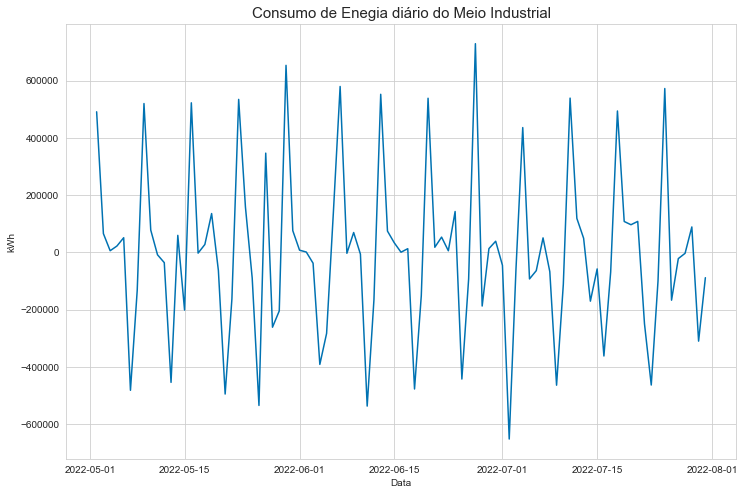

In [37]:
df_day_ind_sample_diff = df_day_ind['05-2022':'07-2022'].diff(1).dropna()

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day_ind_sample_diff, x = df_day_ind_sample_diff.index, y = 'Meio Industrial', ax = ax)
plt.title('Consumo de Enegia diário do Meio Industrial', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.show();


Agora sim, a sazionalidade semanal fica ainda mais clara com os picos acentuados a cada 7 dias

#### Decomposição de Série Temporal

Vamos decompor a serie temporal para obter sua *tendência, sazionalidade e Resíduo*.

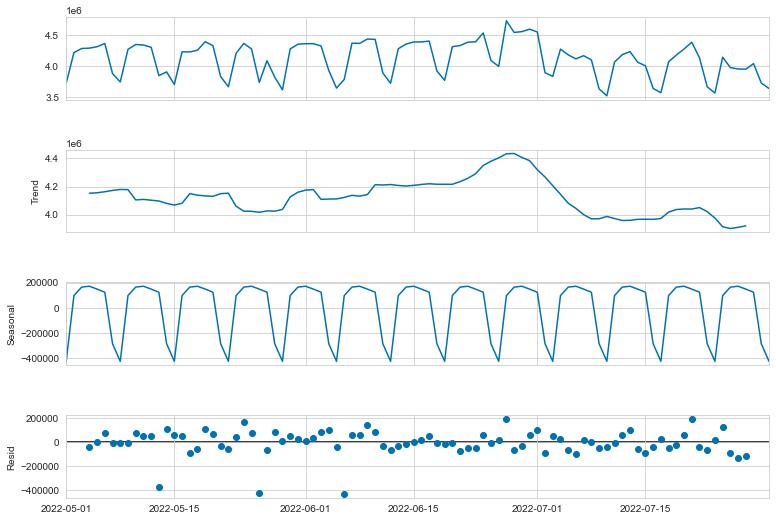

In [38]:
# fig,ax = plt.subplots()
result = seasonal_decompose(df_day_ind['05-2022':'07-2022'], model='additive', period = 7)
fig = result.plot()
fig.set_size_inches(12,8)
plt.show()

mlflow.log_figure(fig, 'decomposition.png')

Muito legal, conseguimos ver que a série realmente possuiu uma **sazionalidade semanal**! Vamos dar uma olhada na decomposição da serie diferenciada.

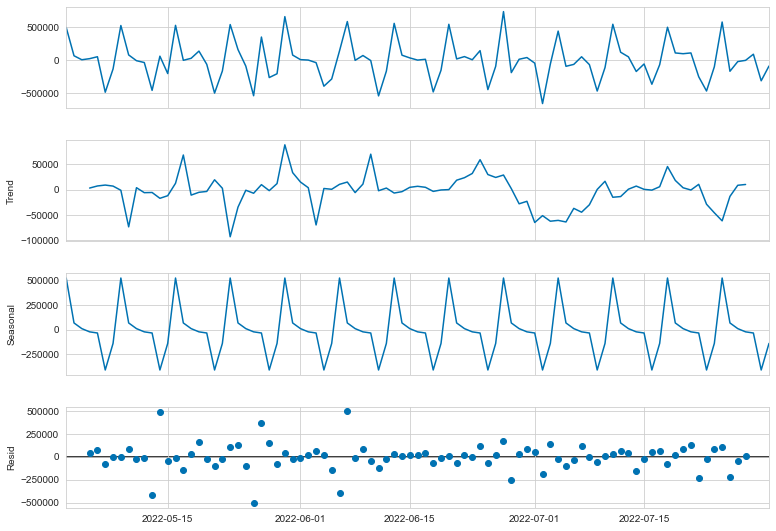

In [39]:
# fig,ax = plt.subplots()
result = seasonal_decompose(df_day_ind_sample_diff, model='additive', period = 7)
fig = result.plot()
fig.set_size_inches(12,8)
plt.show()


Podemos ver ainda mais claramente a sazionalidade do modelo. 

**Os resíduos também tem uma variância menor** e ficam ao redor do zero, além da tendência girar em torno de zero também.

### ACF & PACF + Previsão!

Legal, até agora conseguimos analisar as séries temporarais e deixa-las estacionárias. 

Estamos seguindo mais ou menos o método **Box-Jenkins** para a modelagem de nossos dados. 

Vamos agora tentar descobrir os parametros **p e q** que melhor se ajustam ao modelo ARIMA que vamos implementar. Para isso, plotamos os gráficos **ACF e PACF** das séries afim de estimar esses parametros

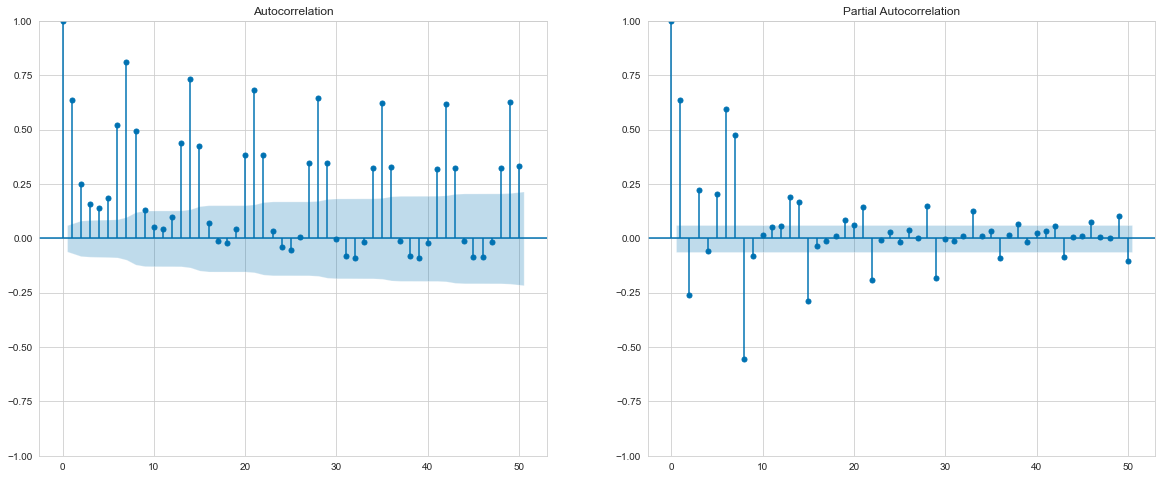

In [40]:
#plotando o gráfico de autocorrelação da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(ncols =2, figsize=(20,8))
ax1 = sm.graphics.tsa.plot_acf(df_day_ind, lags = 50, alpha = 0.05, ax = ax[0])
ax2 = sm.graphics.tsa.plot_pacf(df_day_ind, lags = 50, alpha = 0.05, ax = ax[1])
plt.show()

O modelo parece ter uma queda moderada no gráfico ACF, mas não tem nenhum corte abrupto no PACF. 

Isso provavelmente indica que precisaremos de um modelo ARIMA com parametros *p e q diferentes de zero*. 

Vamos olhar os mesmos dados para a série diferenciada.

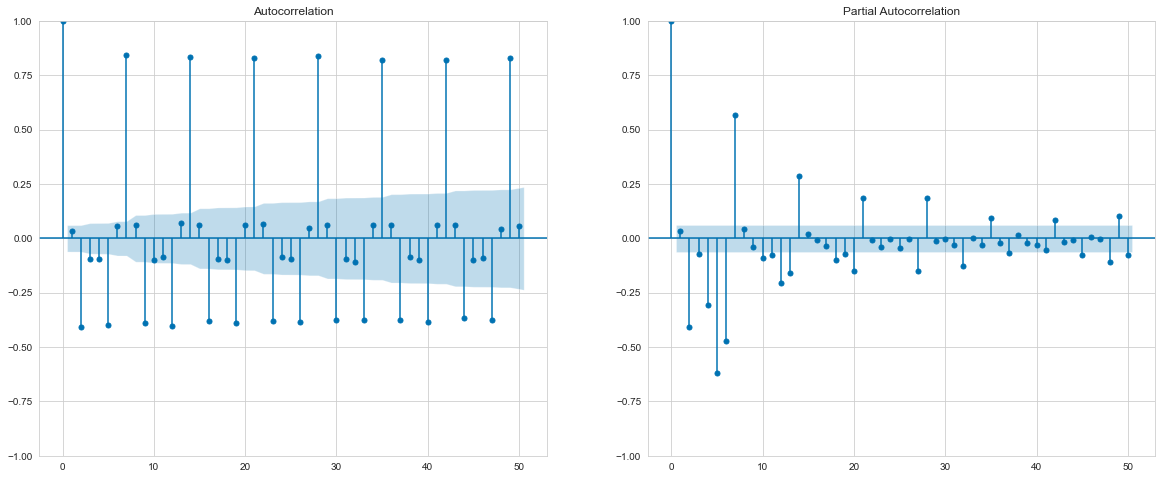

In [41]:
#plotando o gráfico de autocorrelação da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(ncols =2, figsize=(20,8))
ax1 = sm.graphics.tsa.plot_acf(df_day_ind.diff(1).dropna(), lags = 50, alpha = 0.05, ax = ax[0])
ax2 = sm.graphics.tsa.plot_pacf(df_day_ind.diff(1).dropna(), lags = 50, alpha = 0.05, ax = ax[1])
plt.show()

Apesar de melhor, ainda não ficam claros quais os parametros q e p precisamos usar. 

Para a melhor resolução, vamos retirar a sazionalidade differienciando a série semanalmente.

Podemos observar novamente os resultados.

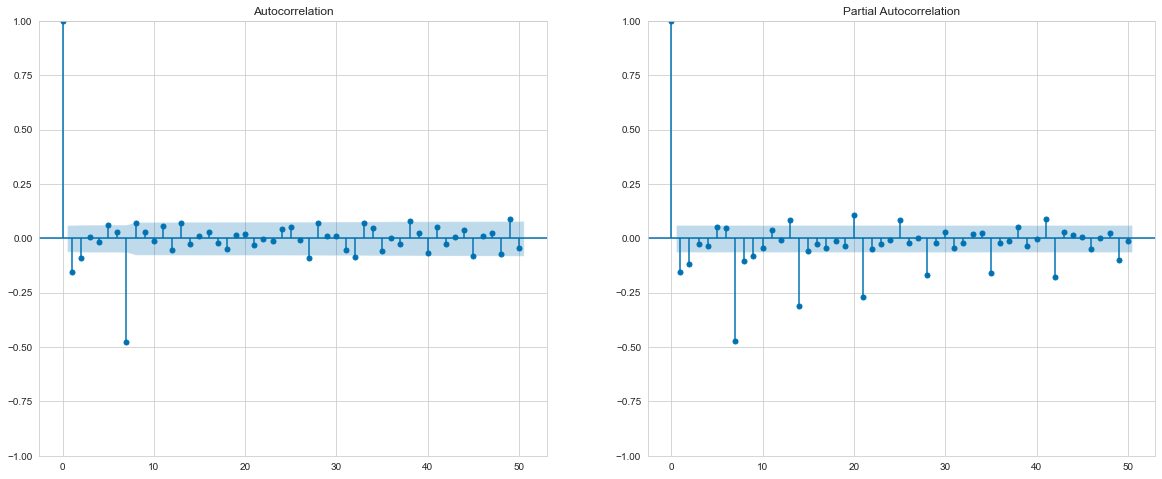

In [42]:
#plotando o gráfico de autocorrelação da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(ncols =2, figsize=(20,8))
ax1 = sm.graphics.tsa.plot_acf(df_day_ind.diff(1).diff(7).dropna(), lags = 50, alpha = 0.05, ax = ax[0])
ax2 = sm.graphics.tsa.plot_pacf(df_day_ind.diff(1).diff(7).dropna(), lags = 50, alpha = 0.05, ax = ax[1])
plt.show()

Agora sim! Temos uma PACF apontando um corte abrupto em lag 7 e uma PACF que descresce aos poucos!

Vamos ajustar primeiramente o modelo ARIMA usando como base o AIC e rodando um for loop! Depois vamos usar o **Auto ARIMA** para ajustar o melhor modelo SARIMA!

Como vimos, precisamos de 1 diferenciação, então ela já será aplicada durante o for loop;

Vamos fazer uma separação entre nossa base de treino e base de teste

In [43]:
x_treino = df_day_ind[:'2023-09-01']
x_test = df_day_ind['2023-09-02':]

Vamos também trabalhar para armazenar os dados de todas as nossas previsões. Isso nos ajudará em um dos entregáveis finais do projeto, que é a construção de um painel com os gráficos de previsão do modelo

In [44]:
x_respostas = x_test.copy()

Para a escolha de um modelo sempre é bom ter um conhecimento da área ou um baseline que nos permita comparar se o valor estimado foi melhor que o calculado previamente. 

Para esse caso em questão vamos usar uma métrica bem comum de baseline, vamos calcular a média movel de consumo dos últimos 7 dias.

Vamos comparar esse resultado com o valor real e utilizar de base para nossa estimativa de melhor modelo.

In [45]:
x_baseline = df_day_ind.rolling(7, closed='left').mean()['2023-09-02':]['Meio Industrial']

In [46]:
metricas = dict()

Para a comparação dos modelos vamos usar duas métricas! 

O MAE e MAPE nos ajudarão a escolher o modelo que melhor se ajustará aos nossos dados.

In [47]:
# MAE para a Regressão Linear
def mae_mape_wmape(y_test, y_pred, name):

    y_pred = pd.DataFrame(np.array(y_pred), index = y_test.index, columns=['Meio Industrial'])

    '''Calcula as estatísticas principais de avaliação do modelo'''

    # MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f'O valor do MAE foi de {round(mae)}')
    mlflow.log_metric(f'mae_{name}', mae)

    # MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    print(f'O valor do MAPE foi de {round(mape, 5)}')
    mlflow.log_metric(f'mape_{name}', mape)    


    metricas[f'metricas_{name}'] = (mae, mape)

    x_respostas[name] = y_pred



In [48]:
mae_mape_wmape(x_test, x_baseline, 'baseline')

O valor do MAE foi de 241342
O valor do MAPE foi de 6.02339


Vamos agora rodar um for loop para buscar os melhores valores de **p e q** que se adptam ao nosso modelo ARIMA!

In [49]:
l = list()
for x in range(5):
    for y in range(5):
        model = sm.tsa.ARIMA(x_treino, order = (x,1,y))
        results = model.fit()
        l.append((results.aic, (x, y)))


c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotando o gráfico com os valores de AIC

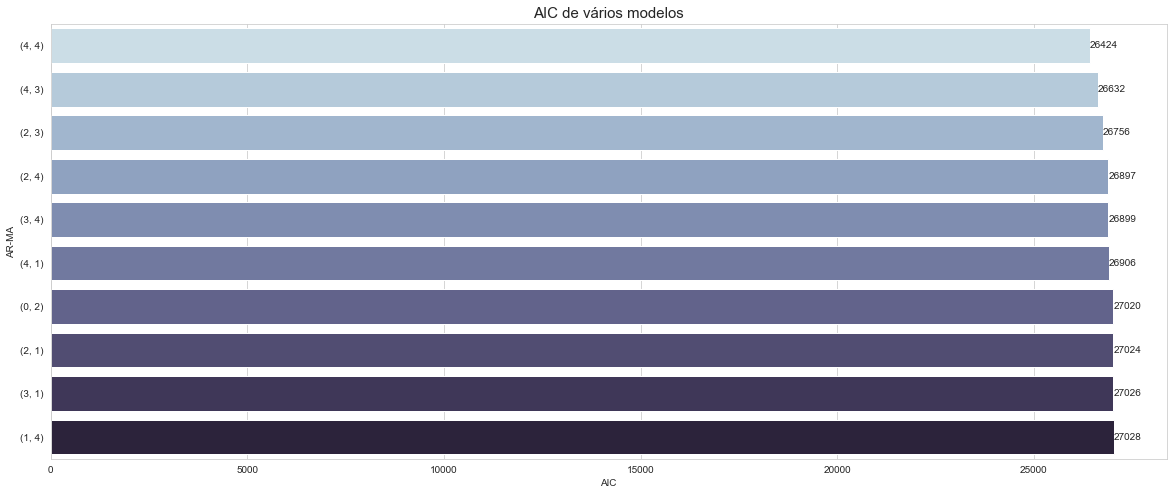

In [50]:
l = pd.DataFrame(l, columns= ['AIC', 'AR-MA'])
plt.figure(figsize = (20,8))
ax = sns.barplot(data = l.sort_values('AIC').head(10), y = 'AR-MA', x='AIC', palette = 'ch:s=.25,rot=-.25')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title('AIC de vários modelos', fontsize=15)
plt.show()

O melhor modelo ARIMA encontrado foi o (4,1,4). 

Porém, perceba que modelos muito mais simples não ficaram longe dos resultados obtidos! O ideal seria testar o **BIC e AIC** ao mesmo tempo e ter parcimonia na escolha.

Por agora, vamos seguir com o 4,1,4 mesmo!

In [51]:
model1 = sm.tsa.ARIMA(x_treino, order = (4,1,4))
results1 = model1.fit()

c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Observando o sumário dos resultados do modelo.

In [52]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Meio Industrial   No. Observations:                  974
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -13202.803
Date:                Mon, 20 Nov 2023   AIC                          26423.606
Time:                        11:41:11   BIC                          26467.529
Sample:                    01-01-2021   HQIC                         26440.322
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8000      0.005    156.911      0.000       0.790       0.810
ar.L2         -1.4349      0.004   -339.146      0.000      -1.443      -1.427
ar.L3          0.8030      0.004    185.955      0.000       0.795       0.811
ar.L4         -0.9872      0.005   -207.101      0.000      -0.997      -0.978
ma.L1         -0.8490      0.013    -66.110      0.000      -0.874      -0.824
ma.L2          1.4302      0.016     87.257      0.000       1.398       1.462
ma.L3         -0.8501      0.018    -47.193      0.000      -0.885      -0.815
ma.L4          0.9800      0.018     55.187      0.000       0.945       1.015
sigma2       6.09e+10   5.06e-15    1.2e+25      0.000    6.09e+10    6.09e+10
===================================================================================
Ljung-Box (L1) (Q):                  37.39   Jarque-Bera (JB):                32.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.08
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+41. Standard errors may be unstable.
"""

Alguns dados aqui são interessantes! 

**O Prob(Q)** que corresponde a hipotese nula de que os residuos são *descorrelacionados* deu menor que 0.05, então não podemos seguir com tal hipótese! 

**O Prob(JB)** que corresponde a hipótese de que os **resíduos seguem uma distribuição normal** deu 0, o que pode ser um problema para nos!

Vamos plotar a **análise gráfica**!

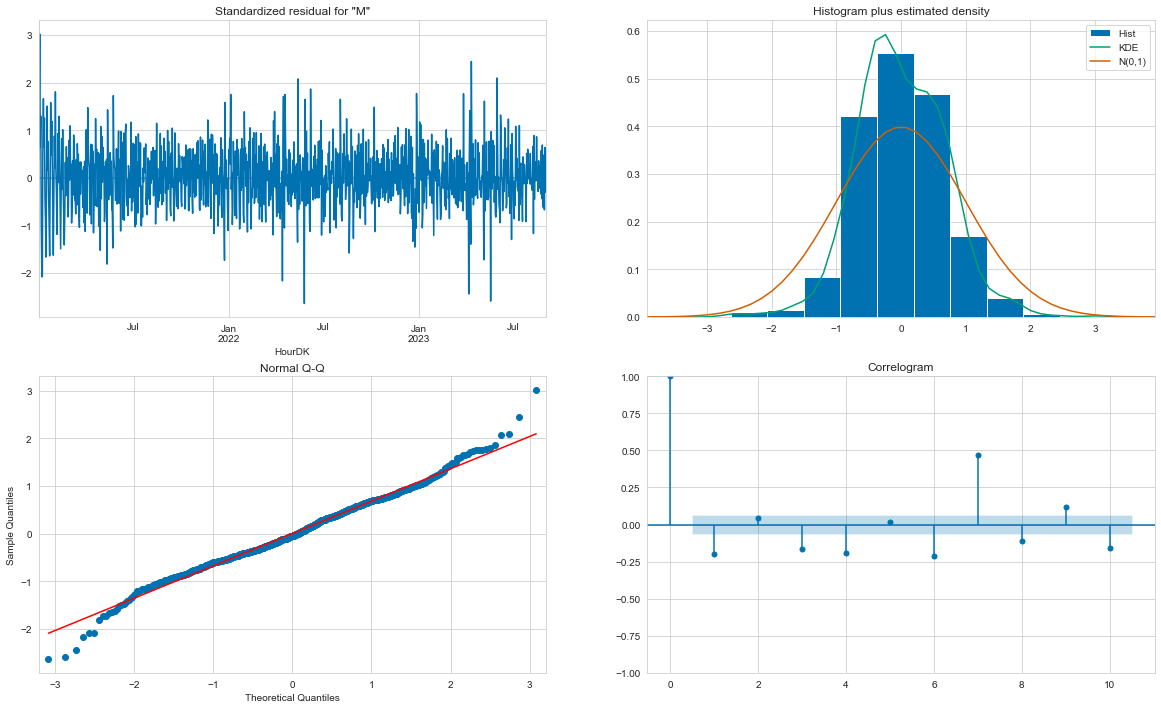

In [53]:
results1.plot_diagnostics(figsize = (20,12))
plt.show();

Podemos extrair várias coisas daqui! A primeira é que a distribuição dos erros é realmente *não normal*! Mas o gráfico Normal Q-Q e Correalograma mostram certa *dependência* do erro com pontos passados, sendo os **resíduos correlacionados**.

Tudo isso parece de certa forma esta ligado ao fato da serie apresentar uma *sazionalidade semanal* que ainda não foi imposta ao modelo! Vamos plotar a nossa base de treino e validar os resultados esperados para verificar a diferença.

Fazendo o Forecast do Modelo

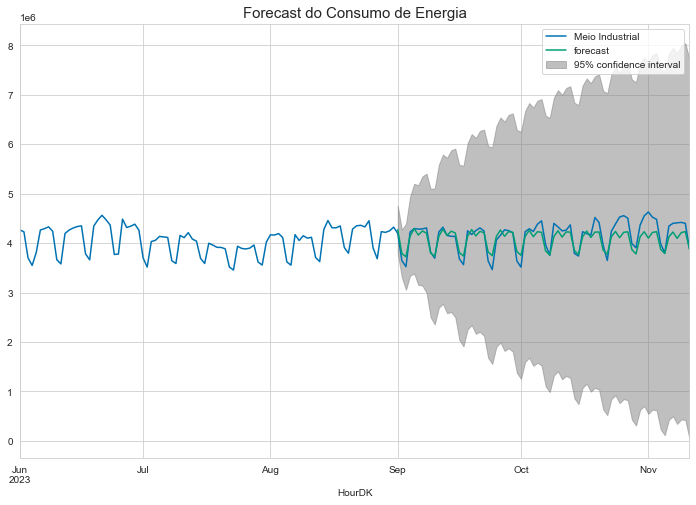

In [54]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize = (12,8))
df_day_ind['2023-06-01':].plot(ax = ax)
plot_predict(results1, '2023-09-01',df_day_ind.index[-1], alpha = 0.05, ax = ax)
plt.title('Forecast do Consumo de Energia', fontsize=15)
plt.show()

Ok! 

O modelo parece se adptar bem aos primeiros dias, mas como estamos fazendo uma previsão longa, devido ao *comportamento de modelos ARIMA*, ele tende a jogar valor próximos a **média da serie**.

Vamos calcular o **MAE**  e **MAPE** da série prevista! 

Essas métricas vão ser a base de nossos estudos!

In [55]:
y_pred = results1.get_forecast(steps = len(x_test)).predicted_mean

In [56]:
mae_mape_wmape(x_test, y_pred, 'ARIMA_manual')

O valor do MAE foi de 137928
O valor do MAPE foi de 3.28904


Vamos agora automatizar um pouco mais nossa abordagem! Vamos usar o *pdmarima* para achar os melhores parametros de um modelo **SARIMA de D=7** para ver se conseguimos melhorar a previsão!


In [57]:
best_model = pm.auto_arima(x_treino,
                          seasonal = True,
                          m = 7,
                          d = 1,
                          D = 1,
                          start_q = 0,
                          start_p = 0,
                          max_q = 5,
                          max_p = 5,
                          infomartion_criteria = 'aic',
                          start_Q = 0,
                          start_P = 0,
                          max_Q = 5,
                          max_P = 5,
                          trace = True,
                          stepwise = True,
                          n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=25994.336, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=25822.174, Time=0.63 sec


 ARIMA(0,1,1)(0,1,1)[7]             : AIC=25657.962, Time=2.00 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=25992.716, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.37 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.24 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=25820.343, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.22 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=25596.867, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=3.17 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=25820.539, Time=0.20 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=25659.695, Time=0.30 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=25654.880, Time=1.91 sec
 ARIMA(0,1,0)(0,1,1)[7] intercept   : AIC=25672.409, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,1,1)[7]          
Total fit time: 17.247 seconds


Legal, temos o melhor modelo encontrado com base na métrica *AIC de (1,1,1)(0,1,2)[7]*. 

Vamos testar e calcular sua métrica MAE, assim como avaliar as estatísticas do modelo

In [58]:
best_model

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [59]:
model2 = SARIMAX(x_treino, order = (0,1,0), seasonal_order = (0,1,1,7))
results2 = model2.fit()

Olhando o sumário

In [60]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     Meio Industrial   No. Observations:                  974
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 7)   Log Likelihood              -12796.433
Date:                             Mon, 20 Nov 2023   AIC                          25596.867
Time:                                     11:41:33   BIC                          25606.613
Sample:                                 01-01-2021   HQIC                         25600.577
                                      - 09-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8567      0.013    -66.645      0.000      -0.882      -0.831
sigma2      1.846e+10   5.13e-14    3.6e+23      0.000    1.85e+10    1.85e+10
===================================================================================
Ljung-Box (L1) (Q):                   9.68   Jarque-Bera (JB):              2931.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Os reusltados de **Prob(JB)** ainda não são animadores. Mas vamos ver o gráficos de análise de resíduos

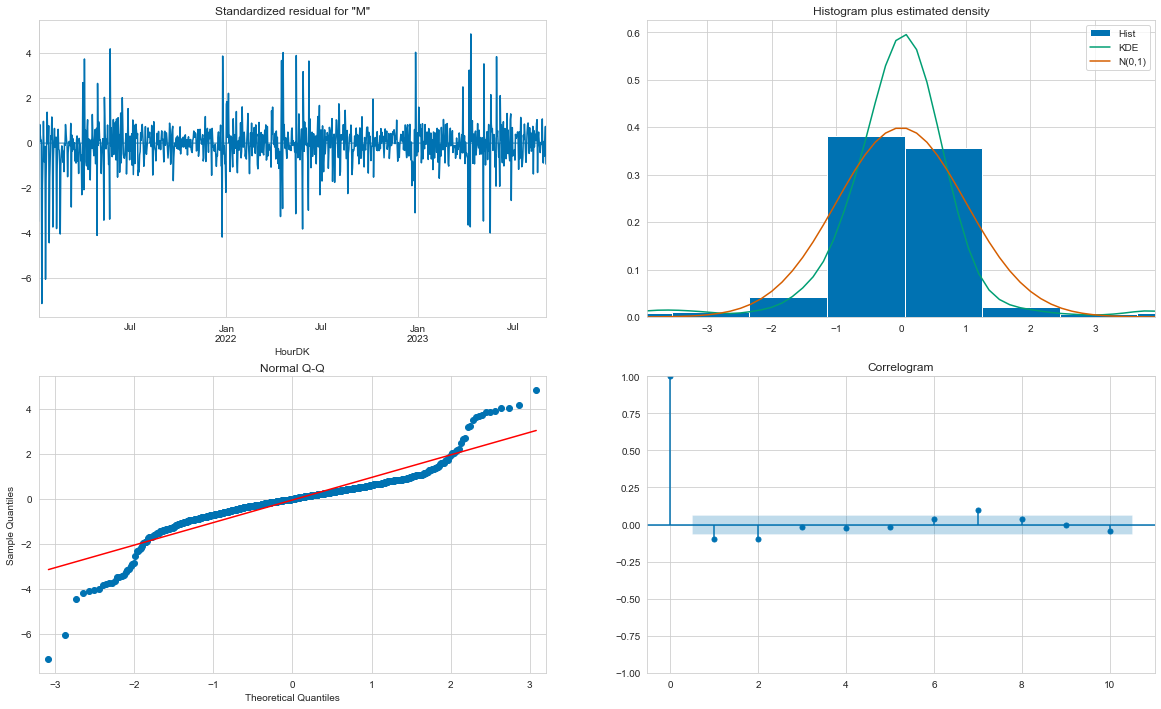

In [61]:
results2.plot_diagnostics(figsize = (20,12))
plt.show();

O correlograma melhorou, porém a distribuição dos resíduos parece ter se *achatado mais em comparação com uma normal*. O **gráfico Q-Q** também desmostra um certo desvio do padrão esperado nas pontas.

Vamos fazer um forecast do modelo SARIMA

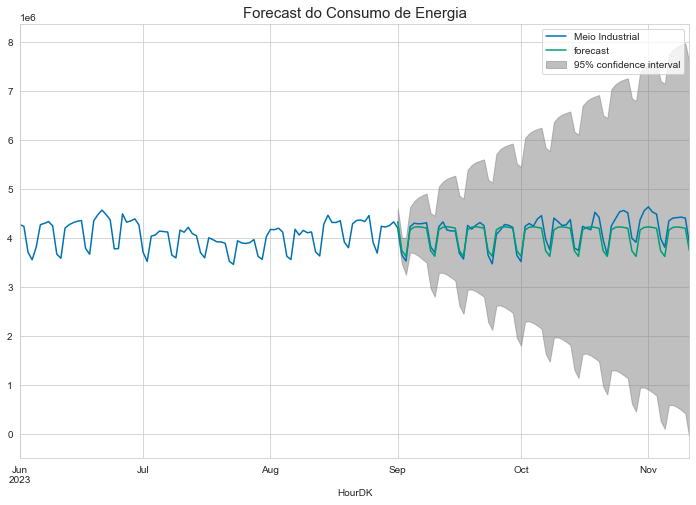

In [62]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize = (12,8))
df_day_ind['2023-06-01':].plot(ax = ax)
plot_predict(results2, '2023-09-01',df_day_ind.index[-1], alpha = 0.05, ax = ax)
plt.title('Forecast do Consumo de Energia', fontsize=15)
plt.show()

A previsão em si parece muito com a do modelo ARIMA, vamos olhar a métrica de sucesso para dizer se a previsão melhorou ou não.

In [63]:
y_pred = results2.get_forecast(steps = len(x_test)).predicted_mean

In [64]:
mae_mape_wmape(x_test, y_pred, 'ARIMA_auto')

O valor do MAE foi de 138323
O valor do MAPE foi de 3.28643


Assim como fizemos para encontrar os valores do modelo SARIMA, vamos ajustar o *pmdarima* também para o modelo ARIMA para ver se econtramos parametros semelhantes ao modelo encontrado usando Box-Jetkins

In [65]:
best_model = pm.auto_arima(x_treino,
                          seasonal = False,
                          d = 1,
                          start_q = 0,
                          start_p = 0,
                          max_q = 8,
                          max_p = 8,
                          infomartion_criteria = 'aic',
                          trace = True,
                          stepwise = True,
                          n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27311.582, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27312.258, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27309.223, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27309.588, Time=0.06 sec


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27160.986, Time=0.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27026.280, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27165.170, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27027.944, Time=1.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27119.467, Time=1.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27089.620, Time=0.76 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27165.627, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=27189.091, Time=1.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=27024.454, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27158.922, Time=0.61 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=27163.206, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=27026.126, Time=0.96 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=27117.924, Time=0.98 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=27310.261, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=27087.968, Time=0.63

In [66]:
model3 = sm.tsa.ARIMA(x_treino, order = (2,1,1))
results3 = model3.fit()

In [67]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Meio Industrial   No. Observations:                  974
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -13508.227
Date:                Mon, 20 Nov 2023   AIC                          27024.454
Time:                        11:41:51   BIC                          27043.976
Sample:                    01-01-2021   HQIC                         27031.884
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6384      0.049     12.988      0.000       0.542       0.735
ar.L2         -0.3650      0.035    -10.426      0.000      -0.434      -0.296
ma.L1         -0.8550      0.022    -38.465      0.000      -0.899      -0.811
sigma2      7.502e+10   2.53e-13   2.97e+23      0.000     7.5e+10     7.5e+10
===================================================================================
Ljung-Box (L1) (Q):                   3.30   Jarque-Bera (JB):                28.21
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.04
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.51e+38. Standard errors may be unstable.
"""

Agora o **Prob(Q)** deu maior que 0.05. Aqui podemos rejeitar a hipotese nula de que os resíduos estão correlacionados!

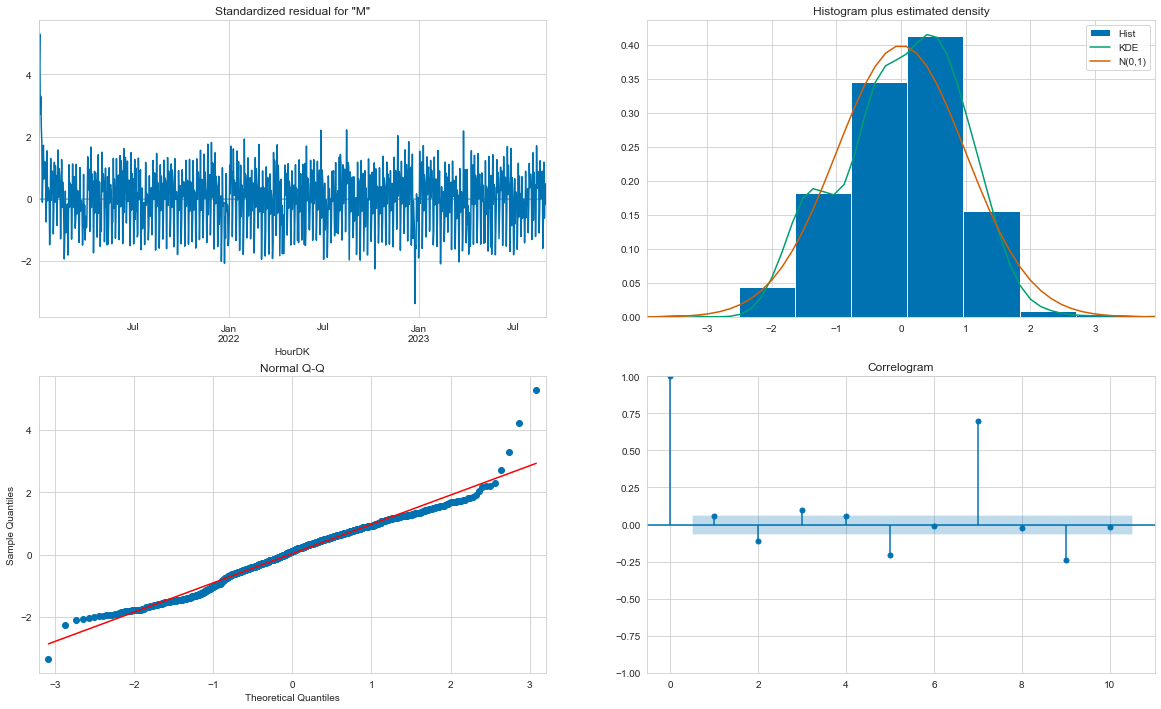

In [68]:
results3.plot_diagnostics(figsize = (20,12))
plt.show();

O Corralograma ainda mostra a correlação de resíduos. O destaque fica para o **lag 7**, que como vimos, influencia bastante na **sazionalidade** da série.

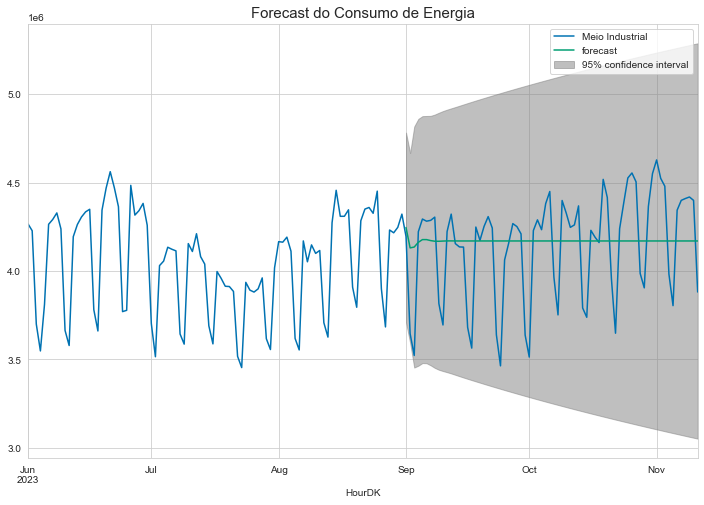

In [69]:
fig, ax = plt.subplots(figsize = (12,8))
df_day_ind['2023-06-01':].plot(ax = ax)
plot_predict(results3, '2023-09-01',df_day_ind.index[-1], alpha = 0.05, ax = ax)
plt.title('Forecast do Consumo de Energia', fontsize=15)
plt.show()

Podemos ver que a previsão foi bem abaixo da dos modelos executados anteriormente. Ainda sim, vamos olhar a métrica de sucesso para uma comparação mais justa.

In [70]:
y_pred = results3.get_forecast(steps = len(x_test)).predicted_mean

In [71]:
mae_mape_wmape(x_test, y_pred, 'ARIMA_auto')

O valor do MAE foi de 236505
O valor do MAPE foi de 5.93044


Realmente, bem abaixo dos outros modelos.

Como podemos ver no resumo final, o modelo **SARIMA** considerando a Sazionalidade semanal do Consumo de Energia possui o **melhor** ajuste ao conjunto de validação! 

A combinação de modelos AR + MA, como diferenciação e aplicação multiplicativa da Sazionalidade nos permitiu obter um resultado **muito bom**!

# 7. Modelos de Apredizado de Maquina

A abordagem classica de modelagem via ARIMA e SARIMA é muito boa e de fácil aplicação. Ela funciona bem mesmo em um **conjunto de dados muito pequenos**!

Porém, nesse caso temos uma quantidade bem grande de dados disponíveis, então pode ser de grande interesse prever a demanda de consumo usando **modelos mais roboustos**, como XGBoostRegressor.

Vamos explorar algumas modelagens e tentar fazer a previsão baseada também nesses fatores!

In [72]:
# Voltando a base de dados original
df_day_ind.head()

,Meio Industrial
HourDK,
2021-01-01,3508699.10
2021-01-02,3614385.41
2021-01-03,3632311.50
2021-01-04,4235753.30
2021-01-05,4218880.91


### Abordagem A


Vamos começar criando algumas variaveis que possam nos ajudar a utilizar modelos de **Machine Learning**. 

Utilizaremos uma *Regressão linear de Ridge*, depois vamos para uma *Random Forest* e por fim um *XGBoostRegressor* 

Porém, antes de tudo, vamos testar a criação de algumas features.

Vamos primeiro construir um modelo baseado em features relativas a *tempo*. 

Pegaremos informações como:
- Dia
- Semana
- Ano
- Dia do ano

Tudo isso será utilizado como feature para a **modelagem** e **predição**

In [73]:
def cria_var(df):
    df2 = df.copy()
    df2['dia_semana'] = df2.index.dayofweek
    df2['Semana_ano'] = df2.index.isocalendar().week    
    df2['mes'] = df2.index.month
    df2['ano'] = df2.index.year
    df2['dia_ano'] = df2.index.dayofyear
    return df2
        

In [74]:
df_day_ind_ml_1 = cria_var(df_day_ind)

In [75]:
df_day_ind_ml_1.head()

,Meio Industrial,dia_semana,Semana_ano,mes,ano,dia_ano
HourDK,,,,,,
2021-01-01,3508699.10,4,53,1,2021,1
2021-01-02,3614385.41,5,53,1,2021,2
2021-01-03,3632311.50,6,53,1,2021,3
2021-01-04,4235753.30,0,1,1,2021,4
2021-01-05,4218880.91,1,1,1,2021,5


Separando a base em treino e teste.

In [76]:
cols = df_day_ind_ml_1.columns[-5:]

x_treino = df_day_ind_ml_1[:'2023-09-01'][cols]
x_test = df_day_ind_ml_1['2023-09-02':df_day_ind.index[-1]][cols]

y_treino = df_day_ind_ml_1[:'2023-09-01']['Meio Industrial']
y_test = df_day_ind_ml_1['2023-09-02':df_day_ind.index[-1]]['Meio Industrial']

In [77]:
x_treino = x_treino.astype({'Semana_ano':'int'})
x_test = x_test.astype({'Semana_ano':'int'})

Criando a função que vai nos ajudar no plot daqui para frente!

In [78]:
def plot_pred(y_pred, y_test):
    y_pred = pd.DataFrame(y_pred, index = y_test.index)

    fig, ax = plt.subplots(figsize = (12,8), sharex = True)
    
    y_test.plot(ax = ax)
    y_pred.plot(ax = ax)
    
    ax.legend(['Valor Real', 'Valor Real'])
    ax.set_title('Comparação de Valores Reais e Previstos')
    plt.show()

    

Vamos agora testar os três modelos.

Para cada um deles vamos também plotar o gráfico dos **resultados** nas bases de teste e avaliar as **métricas** de sucesso.

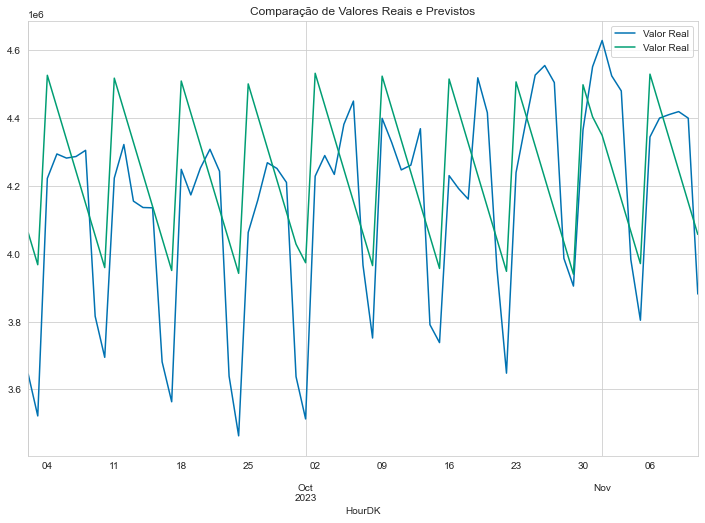

O valor do MAE foi de 202323
O valor do MAPE foi de 5.00443


In [79]:
# Regressão Linear de Ridge

Rdg = Ridge()
Rdg.fit(x_treino, y_treino)
y_pred = Rdg.predict(x_test)


#Plota as comparações de Resultados
plot_pred(y_pred, y_test)

#Calcula as estatísticas do modelo
mae_mape_wmape(y_test, y_pred, 'Rigde_day_features')


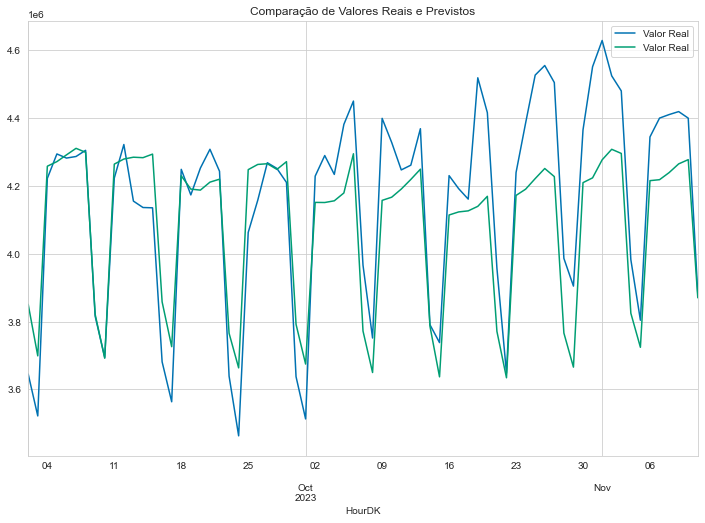

O valor do MAE foi de 128640
O valor do MAPE foi de 3.084


In [80]:
#Random Forest

RF = RandomForestRegressor()
RF.fit(x_treino, y_treino)
y_pred = RF.predict(x_test)

#Plota as comparações de Resultados
plot_pred(y_pred, y_test)

#Calcula as estatísticas do modelo
mae_mape_wmape(y_test, y_pred, 'Random_Forest_day_features')

Vamos explorar como esses resultados

[11:41:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


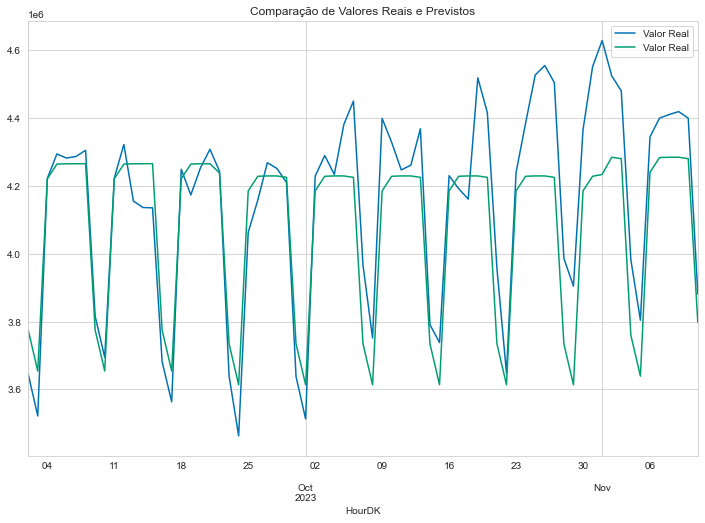

O valor do MAE foi de 118992
O valor do MAPE foi de 2.84853


In [81]:
# XgboostRegressor

xgb_regr = xgb.XGBRegressor()
xgb_regr.fit(x_treino, y_treino)
y_pred = xgb_regr.predict(x_test)

#Plota as comparações de Resultados
plot_pred(y_pred, y_test)

#Calcula as estatísticas do modelo
mae_mape_wmape(y_test, y_pred, 'XGboost_day_features')

#### Abordagem B

Para a abordagem B vamos continuar a previsão usando modelos de Machine Learning, mas dessa vez vamos realizar a criação de **features** de outra forma.

Vamos trabalhar com variáveis Lagadas, ou seja, referentes a períodos passado de maneira fixa.

Vamos construir essas variáveis com uma função.

In [82]:
def cria_var_lag(df):
    df2 = df.copy()
    df2['Shift_30'] = df2['Meio Industrial'].shift(7)
    df2['Shift_45'] = df2['Meio Industrial'].shift(10)
    df2['Shift_120'] = df2['Meio Industrial'].shift(14)
    df2['Shift_180'] = df2['Meio Industrial'].shift(30)
    df2['Shift_360'] = df2['Meio Industrial'].shift(364) 
    return df2.dropna()
        

Aplicando a função!

In [83]:
df_day_ind_ml_2 = cria_var_lag(df_day_ind)

In [84]:
df_day_ind_ml_2

,Meio Industrial,Shift_30,Shift_45,Shift_120,Shift_180,Shift_360
HourDK,,,,,,
2021-12-31,3847980.15,3916600.10,4725209.84,4709240.35,4991585.97,3508699.10
2022-01-01,3636004.76,3919643.08,4609740.26,4154071.37,5080222.70,3614385.41
2022-01-02,3782852.08,3919644.46,4490899.70,3996511.61,5052189.55,3632311.50
2022-01-03,4391183.29,4437664.77,3916600.10,4589588.45,4369186.49,4235753.30
2022-01-04,4516858.19,4466537.81,3919643.08,4725209.84,4343366.30,4218880.91
...,...,...,...,...,...,...
2023-11-07,4399539.00,4550891.01,3986178.12,4385002.41,3751432.36,4181675.91
2023-11-08,4409916.12,4628247.94,3904429.07,4526257.37,4398751.82,4204170.49
2023-11-09,4418701.09,4524028.88,4364835.82,4554499.44,4327674.08,4270434.08


Novamente separando a base entre treino e teste. Sempre fazemos o treinamento usando apenas uma parte do dataset, depois testamos os resultados!

In [85]:
cols = df_day_ind_ml_2.columns[-5:]

x_treino = df_day_ind_ml_2[:'2022-08-01'][cols]
x_test = df_day_ind_ml_2['2023-09-02':df_day_ind.index[-1]][cols]

y_treino = df_day_ind_ml_2[:'2022-08-01']['Meio Industrial']
y_test = df_day_ind_ml_2['2023-09-02':df_day_ind.index[-1]]['Meio Industrial']

In [86]:
x_treino.head()

,Shift_30,Shift_45,Shift_120,Shift_180,Shift_360
HourDK,,,,,
2021-12-31,3916600.10,4725209.84,4709240.35,4991585.97,3508699.10
2022-01-01,3919643.08,4609740.26,4154071.37,5080222.70,3614385.41
2022-01-02,3919644.46,4490899.70,3996511.61,5052189.55,3632311.50
2022-01-03,4437664.77,3916600.10,4589588.45,4369186.49,4235753.30
2022-01-04,4466537.81,3919643.08,4725209.84,4343366.30,4218880.91


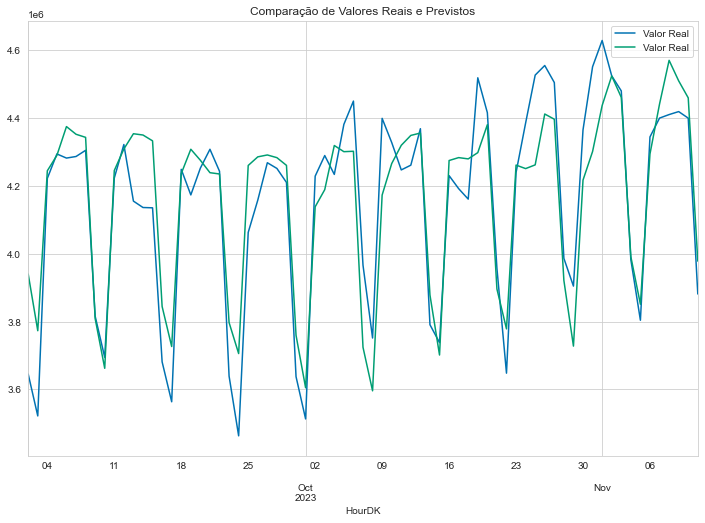

O valor do MAE foi de 103340
O valor do MAPE foi de 2.53491


In [87]:
Rdg = Ridge()
Rdg.fit(x_treino, y_treino)
y_pred = Rdg.predict(x_test)

#Plota as comparações de Resultados
plot_pred(y_pred, y_test)

#Calcula as estatísticas do modelo
mae_mape_wmape(y_test, y_pred, 'Ridge_lag_day')

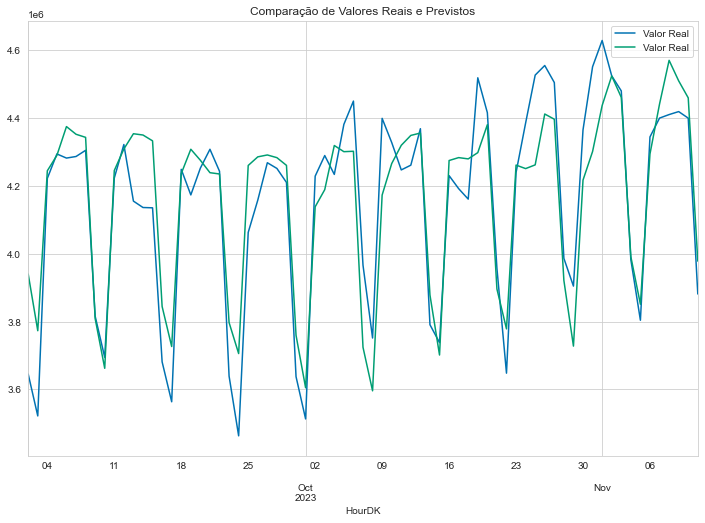

O valor do MAE foi de 103340
O valor do MAPE foi de 2.53491


In [88]:
RF = RandomForestRegressor()
RF.fit(x_treino, y_treino)
y_pred = RF.predict(x_test)


#Plota as comparações de Resultados
plot_pred(y_pred, y_test)

#Calcula as estatísticas do modelo
mae_mape_wmape(y_test, y_pred, 'Random_Forest_lag_day')

[11:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


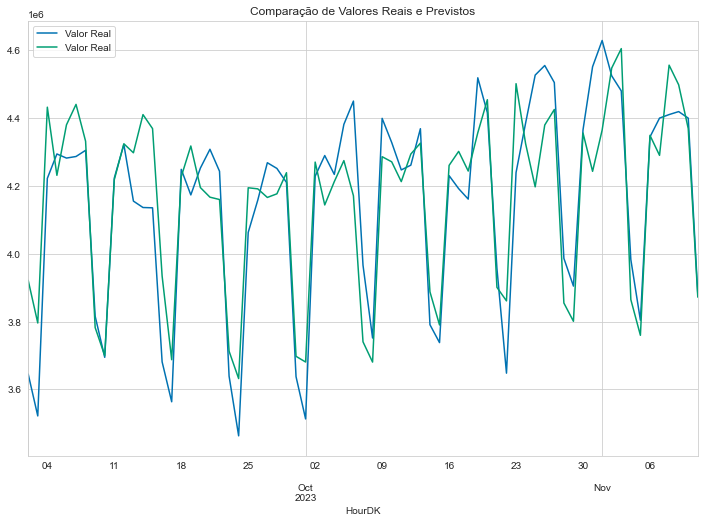

O valor do MAE foi de 111071
O valor do MAPE foi de 2.70415


In [89]:
xgb_regr = xgb.XGBRegressor()
xgb_regr.fit(x_treino, y_treino)
y_pred = xgb_regr.predict(x_test)

#Plota as comparações de Resultados
plot_pred(y_pred, y_test)

#Calcula as estatísticas do modelo
mae_mape_wmape(y_test, y_pred, 'XGBoost_lag_day')


In [90]:
x_respostas.head()

,Meio Industrial,baseline,ARIMA_manual,ARIMA_auto,Rigde_day_features,Random_Forest_day_features,XGboost_day_features,Ridge_lag_day,Random_Forest_lag_day,XGBoost_lag_day
HourDK,,,,,,,,,,
2023-09-02,3645261.85,4113598.73,3786259.56,4130560.83,4061857.89,3850666.98,3774738.75,3940006.27,3940006.27,3921313.75
2023-09-03,3521800.02,4077172.17,3722827.07,4135509.11,3967400.16,3698806.57,3653979.25,3772906.96,3772906.96,3795675.25
2023-09-04,4221908.33,4054085.22,4141232.08,4162236.16,4525685.75,4257736.89,4220788.50,4244321.29,4244321.29,4431697.50
2023-09-05,4293849.76,4052657.54,4290439.51,4177493.62,4431228.03,4271268.95,4263989.50,4289691.68,4289691.68,4230860.00
2023-09-06,4281695.41,4063780.06,4162155.39,4177479.22,4336770.30,4291098.37,4264971.50,4374522.41,4374522.41,4379624.00


Vamos armazenar os resultados e a base completa para olhar posteriomente.

In [111]:
pd.concat([df_day_ind, x_respostas]).to_parquet('Previsoes.parquet')

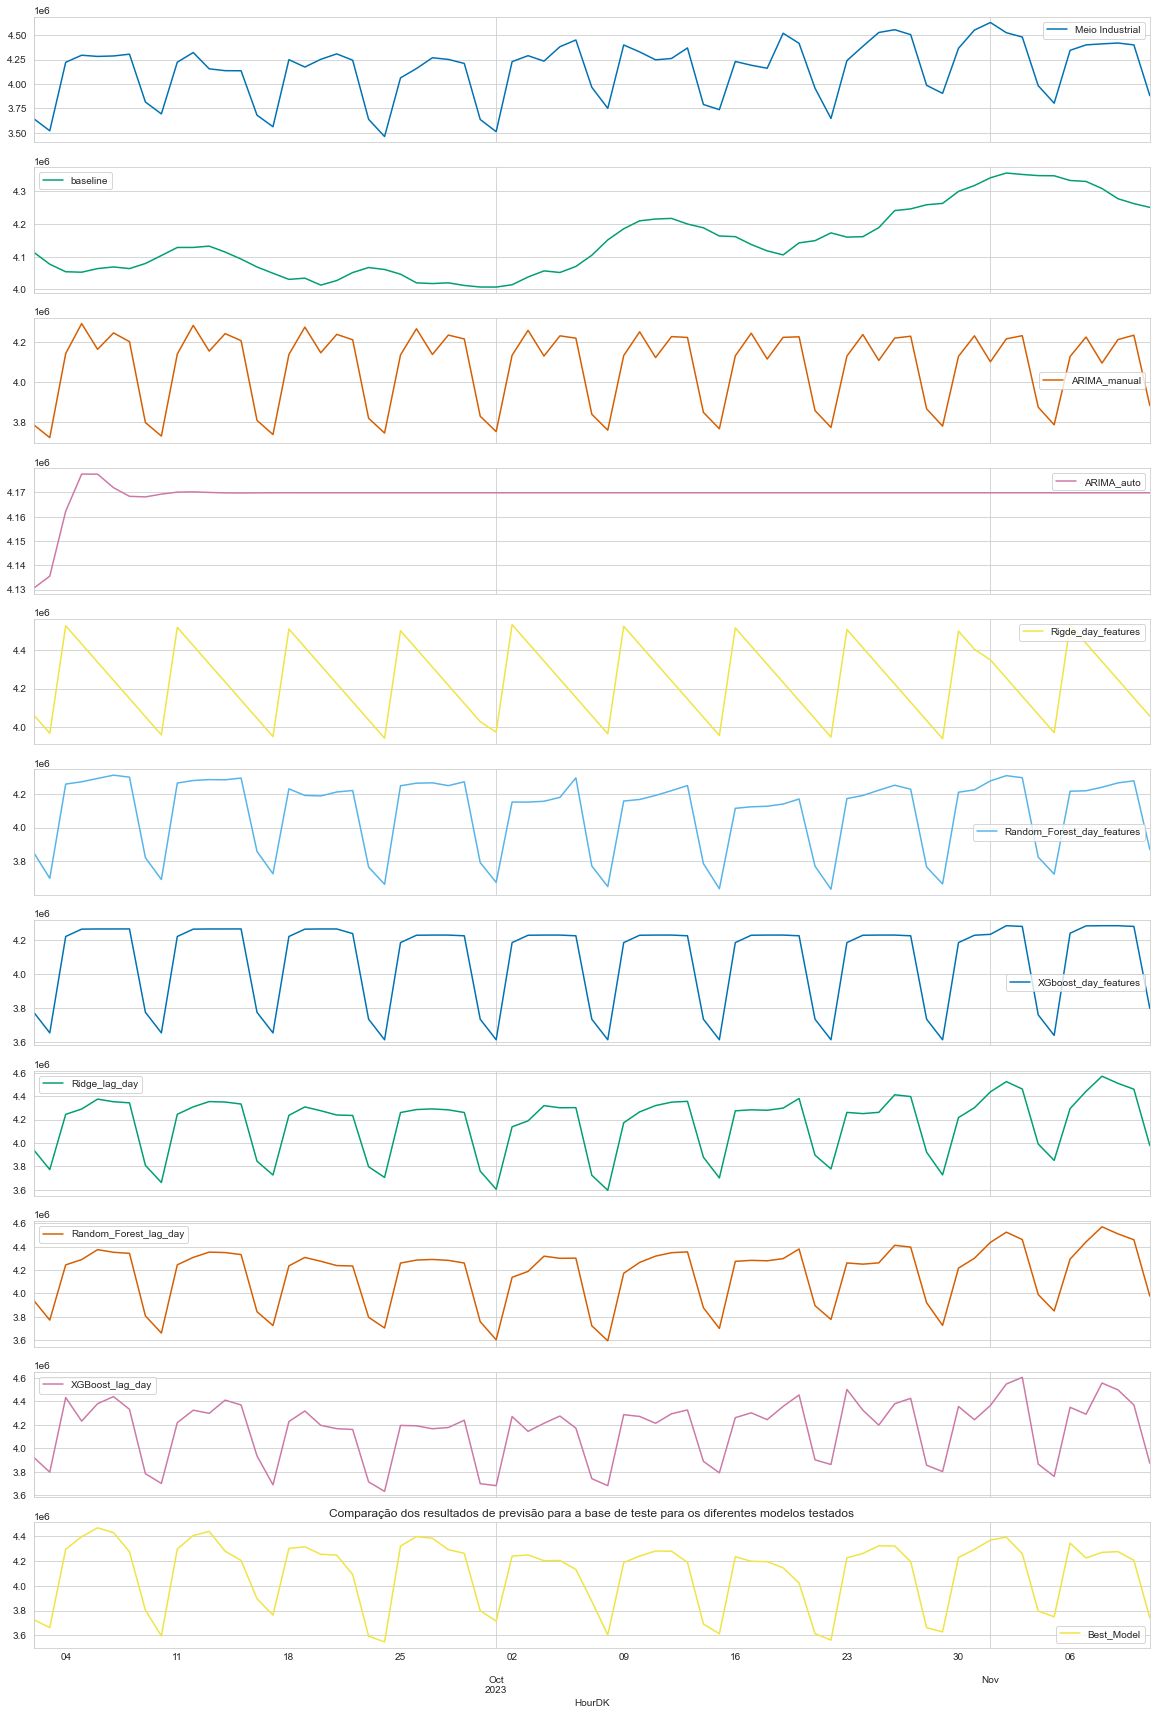

In [113]:
x_respostas.plot(subplots = True, figsize = (20,30))
plt.title('Comparação dos resultados de previsão para a base de teste para os diferentes modelos testados')
plt.show()

In [92]:
df_metricas = pd.DataFrame.from_dict(metricas, orient='index', columns= ['MAE', 'MAPE'])
df_metricas.to_csv('metricas.csv')
df_metricas.sort_values('MAPE')

,MAE,MAPE
metricas_Ridge_lag_day,103340.01,2.53
metricas_Random_Forest_lag_day,103340.01,2.53
metricas_XGBoost_lag_day,111071.24,2.70
metricas_XGboost_day_features,118992.46,2.85
metricas_Random_Forest_day_features,128640.15,3.08
metricas_ARIMA_manual,137928.28,3.29
metricas_Rigde_day_features,202322.68,5.00
metricas_ARIMA_auto,236505.08,5.93
metricas_baseline,241342.49,6.02


Observando o resultado obtido, temos que o melhor modelo encontrado foi o modelo de Ridge com o uso de features baseadas no dia da previsão!

Porém, para a tunagem de hiperparâmetros vamos escolher o XGBoost, simplismente por uma preferência pessoal! 

Vamos agora tunar os hiperparâmetros para ver se conseguimos obter métricas ainda melhores!

Passamos alguns parametros ao RandomSeach para nos ajudar a encontrar os melhores valores que minimizam nossa métrica

In [93]:
cols = df_day_ind_ml_1.columns[-5:]

x_treino = df_day_ind_ml_1[:'2023-09-01'][cols]
x_test = df_day_ind_ml_1['2023-09-02':df_day_ind.index[-1]][cols]

y_treino = df_day_ind_ml_1[:'2023-09-01']['Meio Industrial']
y_test = df_day_ind_ml_1['2023-09-02':df_day_ind.index[-1]]['Meio Industrial']

In [94]:
x_treino = x_treino.astype({'Semana_ano':'int'})
x_test = x_test.astype({'Semana_ano':'int'})

Aqui passamos alguns parametros de teste e também informamos qual o tipo de divisão deve ser feita no *cross validation*, usando o *TimeSeriesSplit*.

In [95]:
parametros = {
    'learning_rate': [0.00001,0.0001, 0.001, 0.01, 0.1, 1],
    'n_estimators': [10, 100, 200, 500, 1000, 2000, 5000]
}

xgb_regr = xgb.XGBRegressor()

tscv = TimeSeriesSplit(n_splits=3)

RSCV = RandomizedSearchCV(xgb_regr, parametros, cv=tscv.split(x_test), n_jobs=4, scoring="neg_mean_absolute_error")
RSCV.fit(x_treino, y_treino)

print(RSCV.best_params_)
print(RSCV.best_score_)

[11:42:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 1000, 'learning_rate': 1}
-143475.7864901961


Vamos agora replicar o melhor modelo na base de teste e anexar a nosso DataFrame de métricas

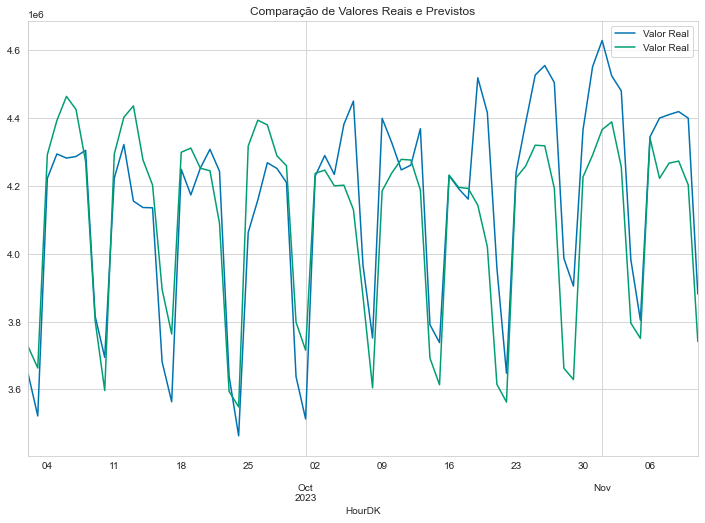

O valor do MAE foi de 139032
O valor do MAPE foi de 3.34433


In [96]:
best_modelo = RSCV.best_estimator_
y_pred = best_modelo.predict(x_test)

#Plota as comparações de Resultados
plot_pred(y_pred, y_test)

#Calcula as estatísticas do modelo
mae_mape_wmape(y_test, y_pred, 'Best_Model')


O interessante é que o modelo aqui apresenteou um **MAPE** bem maior que anteriormente! 

Isso pode ter muita influência do fato de não termos usado **Cross Validation durante o cálculo das métricas anteriores**! 

Muito provavelmente se usassemos teriamos resultados diferentes que poderiam influenciar na decisão!


Vamos calcular a importância de cada uma features na previsão do modelo.

<BarContainer object of 5 artists>

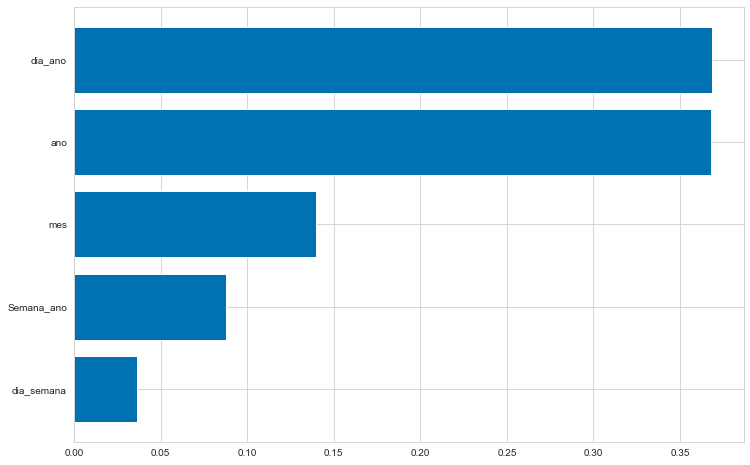

In [97]:
plt.figure(figsize=(12,8))
plt.barh(width = sorted(best_modelo.feature_importances_), y = x_test.columns)

Podemos ver a alta influência do dia no ano na previsão, além do ano em si.

Legal, agora que temos um modelo com os dados totais, vamos tentar predizer os próximos 60 dias de consumo a partir da data máxima importada!

In [98]:
df_day_ind_ml_2.tail()

,Meio Industrial,Shift_30,Shift_45,Shift_120,Shift_180,Shift_360
HourDK,,,,,,
2023-11-07,4399539.00,4550891.01,3986178.12,4385002.41,3751432.36,4181675.91
2023-11-08,4409916.12,4628247.94,3904429.07,4526257.37,4398751.82,4204170.49
2023-11-09,4418701.09,4524028.88,4364835.82,4554499.44,4327674.08,4270434.08
2023-11-10,4399418.08,4479698.21,4550891.01,4504371.54,4246797.15,4280495.15
2023-11-11,3881105.44,3982460.94,4628247.94,3986178.12,4260787.47,3760911.02


Fitando os modelo com todos os dados postetior ao treinamento

In [122]:
cols = df_day_ind_ml_1.columns[-5:]

#Treinando com todos os dados para prever o futuro
x_treino = df_day_ind_ml_1[cols]
y_treino = df_day_ind_ml_1['Meio Industrial']

x_treino = x_treino.astype({'Semana_ano':'int'})
x_test = x_test.astype({'Semana_ano':'int'})


xgb_regr_bm = xgb.XGBRegressor(**RSCV.best_params_)
xgb_regr_bm.fit(x_treino, y_treino)


[12:16:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=1, n_estimators=1000)

Criando o novo dataframe com datas futuras!

Como dito, vamos tentar prever os próximos 60 dias!

In [140]:
#Maior valor de data
inicio = df_day_ind_ml_1.index.max()
datas_futuras = pd.date_range(inicio, inicio + timedelta(days=60))
datas_futuras = pd.DataFrame(index = datas_futuras)


datas_futuras['Futuro'] = True
df_day_ind['Futuro'] = False

df_day_ind_fut = pd.concat([df_day_ind, datas_futuras])

Criando as features necessárias!

In [141]:
df_day_ind_fut_day_feature = cria_var(df_day_ind_fut)
df_day_ind_fut_day_feature = df_day_ind_fut_day_feature.astype({'Semana_ano':'int'})

Filtrando apenas os dados mais futuros!

In [142]:
cols = df_day_ind_fut_day_feature.columns[-5:]
df_day_ind_fut_lag = df_day_ind_fut_day_feature[df_day_ind_fut_day_feature['Futuro'] == True][cols]

df_day_ind_fut_lag.head()

,dia_semana,Semana_ano,mes,ano,dia_ano
2023-11-11,5,45,11,2023,315
2023-11-12,6,45,11,2023,316
2023-11-13,0,46,11,2023,317
2023-11-14,1,46,11,2023,318
2023-11-15,2,46,11,2023,319


Realizando a previsão e jogando em um novo DataFrame

In [144]:
y_pred = xgb_regr_bm.predict(df_day_ind_fut_lag)
y_pred = pd.DataFrame(y_pred, index = df_day_ind_fut_lag.index, columns = ['Meio_Industrial_pred'])

Plotando os resultados obtidos!

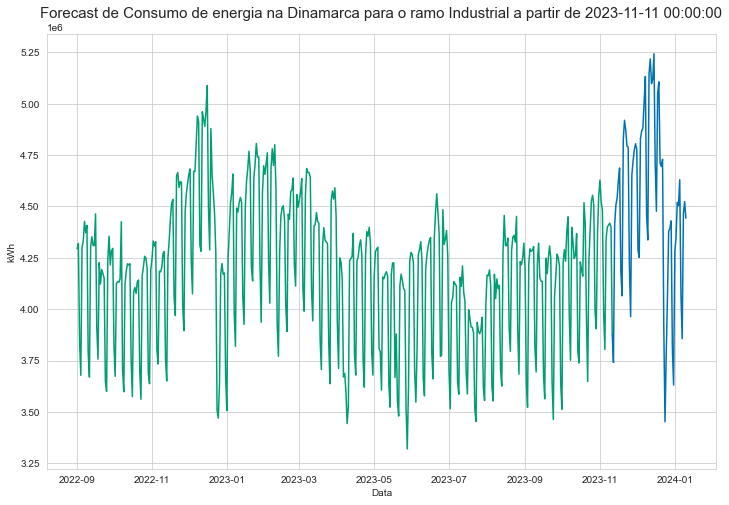

In [148]:
#Plota as comparações de Resultados

limite = df_day_ind_ml_2['2022-09-01':]

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = y_pred, x = y_pred.index, y = y_pred['Meio_Industrial_pred'], ax = ax)
sns.lineplot(data = limite, x = limite.index, y = limite['Meio Industrial'], ax = ax)
plt.title(f'Forecast de Consumo de energia na Dinamarca para o ramo Industrial a partir de {inicio}', fontsize=15)
plt.ylabel('kWh', fontsize=10)
plt.xlabel('Data', fontsize=10)
plt.show()

In [ ]:
mlflow.end_run()

# 8. Conclusão

O projeto teve como objetivo testar diversos conhecimentos.

Usou-se de dados de uma API pública e Mlfow para controle de experimento!

Fizemos uma EDA explorando diversos métodos de análise de séries temporais. 

Testamos algumas das metodologias principais para séries temporais. Testamos modelos clássicos como ARIMA e SARIMA, avaliamos a sazionalidade via gráfico e testes de hipótese.

Ainda testamos modelos mais atuais, de aprendizado de máquina. Utilizamos 3 modelos diferentes em 2 abordagns diferentes.

Para um dos modelos escolhidos fizemos a tunagem dos hiperparâmetros.

Por fim, para esse modelo tunado fizamos a previsão de valores para os próximos 60 dias.

O MAPE do modelo tunado foi de 3.3, então podemos enteder que fizemos a previsão com mais ou menos **3.3% de Sucesso**! Conseguimos reduzir em quase **50%** o erro do **baseline de 6%**!

Falta
- Terminar o README.md

Possiveis Extras
- Usar Cloud e Rodar todo o dia?
- Usar o prophet, LGBM
- Previsão para todas as meios consumidores
- Usar 1 modelo de Deep Learning
- Deploy usando Flask?